# Fake and Real News Classification

In this project we will build a model to classify fake or real news using the data available on Kaggle. 
Link: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

The dataset can be used by anyone who wants to learn about basics of natural language porocessing and model building. 

Table of Contents:

1. Importing Libraries
2. Importing Data
3. Data Analysis and Data Cleaning
4. Feature Engineering
5. Model Building
6. Model Evaluation
7. Future Research 

Note: In this notebook I have used seaborn and matplotlib as visualization libraries but there are much interactive libraries like plotly that can be used for visualization. 

## Importing Libraries

In [135]:
import numpy as np
import pandas as pd
import re, string
import math

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from collections import Counter
from collections import OrderedDict 

import nltk
nltk.download('stopwords')
#nltk.download()
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer

from sklearn.utils import shuffle
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


_____

## Importing Data

Our data is available in 2 different datasets, fake and real news data. We will combine these datasets into one dataframe for further analysis. We will also build a new column for target column called __target__.  

In [136]:
fake_news_data = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
# Change import paths based on directory

In [137]:
real_news_data = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")
# Change import paths based on directory

Let's check if the columns of our dataframes are similar, make target column and combine these dataframes. 

In [138]:
real_news_data.columns == fake_news_data.columns

array([ True,  True,  True,  True])

In [139]:
fake_news_data["target"] = "fake"

In [140]:
real_news_data["target"] = "real"

In [141]:
print("Our combined dataset should have %d rows." %(fake_news_data.shape[0] + real_news_data.shape[0]))

Our combined dataset should have 44898 rows.


In [142]:
news_df = real_news_data.append(fake_news_data).reset_index(drop=True)

In [143]:
assert news_df.shape[0] == 44898

_____
____

## Data Analysis

In data analysis we will look at the following aspects of the data: column names/structure/types, missing data, column values distribution and since we have text data, we will look into: words distribution.

In [144]:
news_df.sample(10)

title  \
13799  Vietnam court jails blogger for seven years fo...   
9745   Republicans, Obama immigration chief clash ove...   
3239   U.S. federal government can pay bills through ...   
29759   Donald Trump Makes Pathetic, Racist Swipe At ...   
25048   Trump SURRENDERS, Admits His Business Is A Co...   
364    Kremlin says Putin not influenced by ex-Trump ...   
18805  U.N. agrees new team of experts for Burundi bu...   
25712   Alec Baldwin NAILS Trump’s ‘Grab Them by the ...   
9929   John Kerry: Carnival should not bar Cuban-Amer...   
28620   Trump’s Pick For Supreme Court Justice Shows ...   

                                                    text       subject  \
13799  (Reuters) - A court in Vietnam jailed a blogge...     worldnews   
9745   WASHINGTON (Reuters) - The chief of U.S. Immig...  politicsNews   
3239   WASHINGTON (Reuters) - The U.S. federal govern...  politicsNews   
29759  President Obama s speech from a mosque in Balt...          News   
25048  Donald Trump is finally dealing with the massi...          News   
364    MOSCOW (Reuters) - The Kremlin said on Monday ...  politicsNews   
18805  GENEVA (Reuters) - The U.N. Human Rights Counc...     worldnews   
25712  Who didn t miss Saturday Night Live s take on ...          News   
9929   MIAMI (Reuters) - U.S. Secretary of State John...  politicsNews   
28620  The GOP has been absolutely obsessed with bloc...          News   

                      date target  
13799   November 27, 2017    real  
9745       April 28, 2016    real  
3239        June 12, 2017    real  
29759     February 4, 2016   fake  
25048    November 30, 2016   fake  
364      December 4, 2017    real  
18805  September 28, 2017    real  
25712      October 9, 2016   fake  
9929       April 14, 2016    real  
28620       March 30, 2016   fake

In [145]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'target'], dtype='object')

In [146]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


> We don't have any missing data in our dataset. All the columns are of type object inlcuding date column. We have title of news, news text, news subject, date of news and target column for fake or real news. 

In [147]:
news_df.describe()

title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   

             subject                date target  
count          44898               44898  44898  
unique             8                2397      2  
top     politicsNews  December 20, 2017    fake  
freq           11272                 182  23481

____

#### target

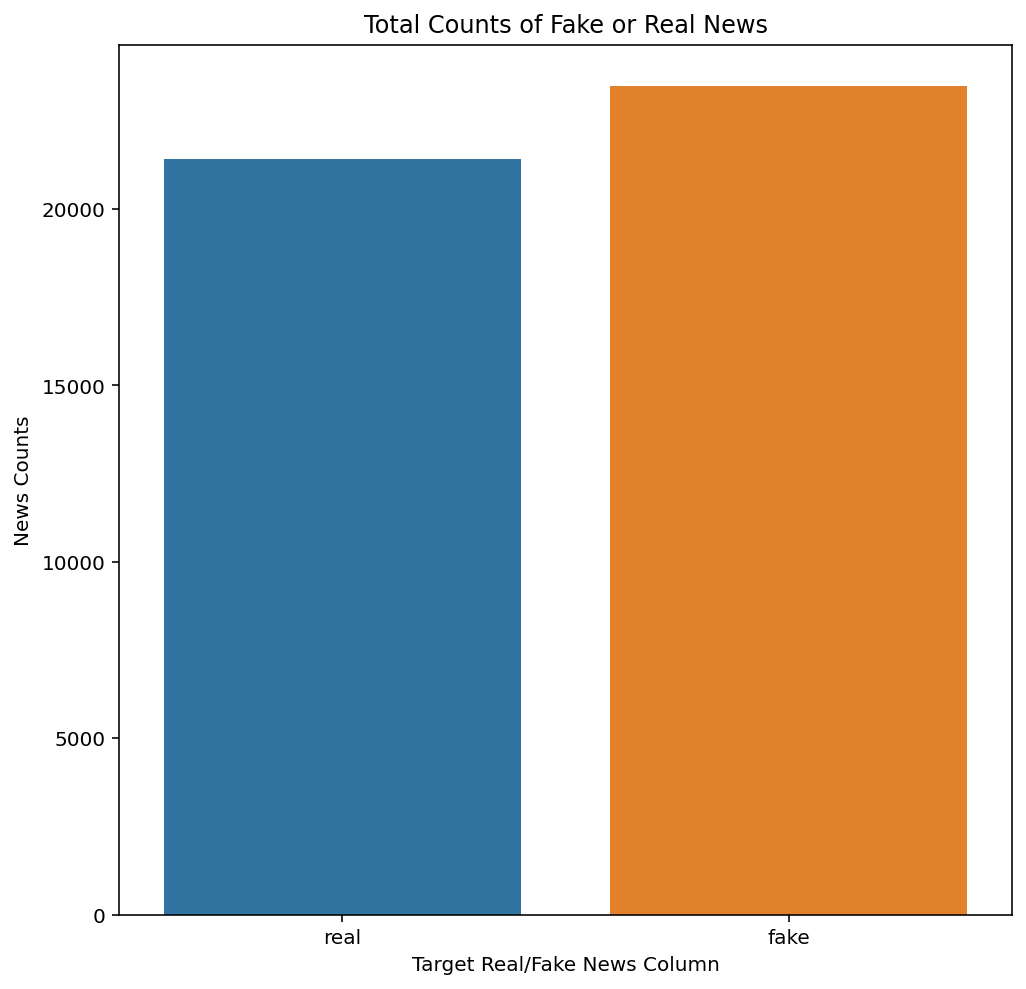

In [148]:
plt.figure(figsize=(8, 8))
sns.countplot(x="target", data=news_df)
plt.title("Total Counts of Fake or Real News")
plt.xlabel("Target Real/Fake News Column")
plt.ylabel("News Counts")
plt.show()

> Our data set is not a highly imbalanced dataset. A slight imbalance may represent the real world distribution of news. 

____

#### subject

In [149]:
news_df.subject.unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

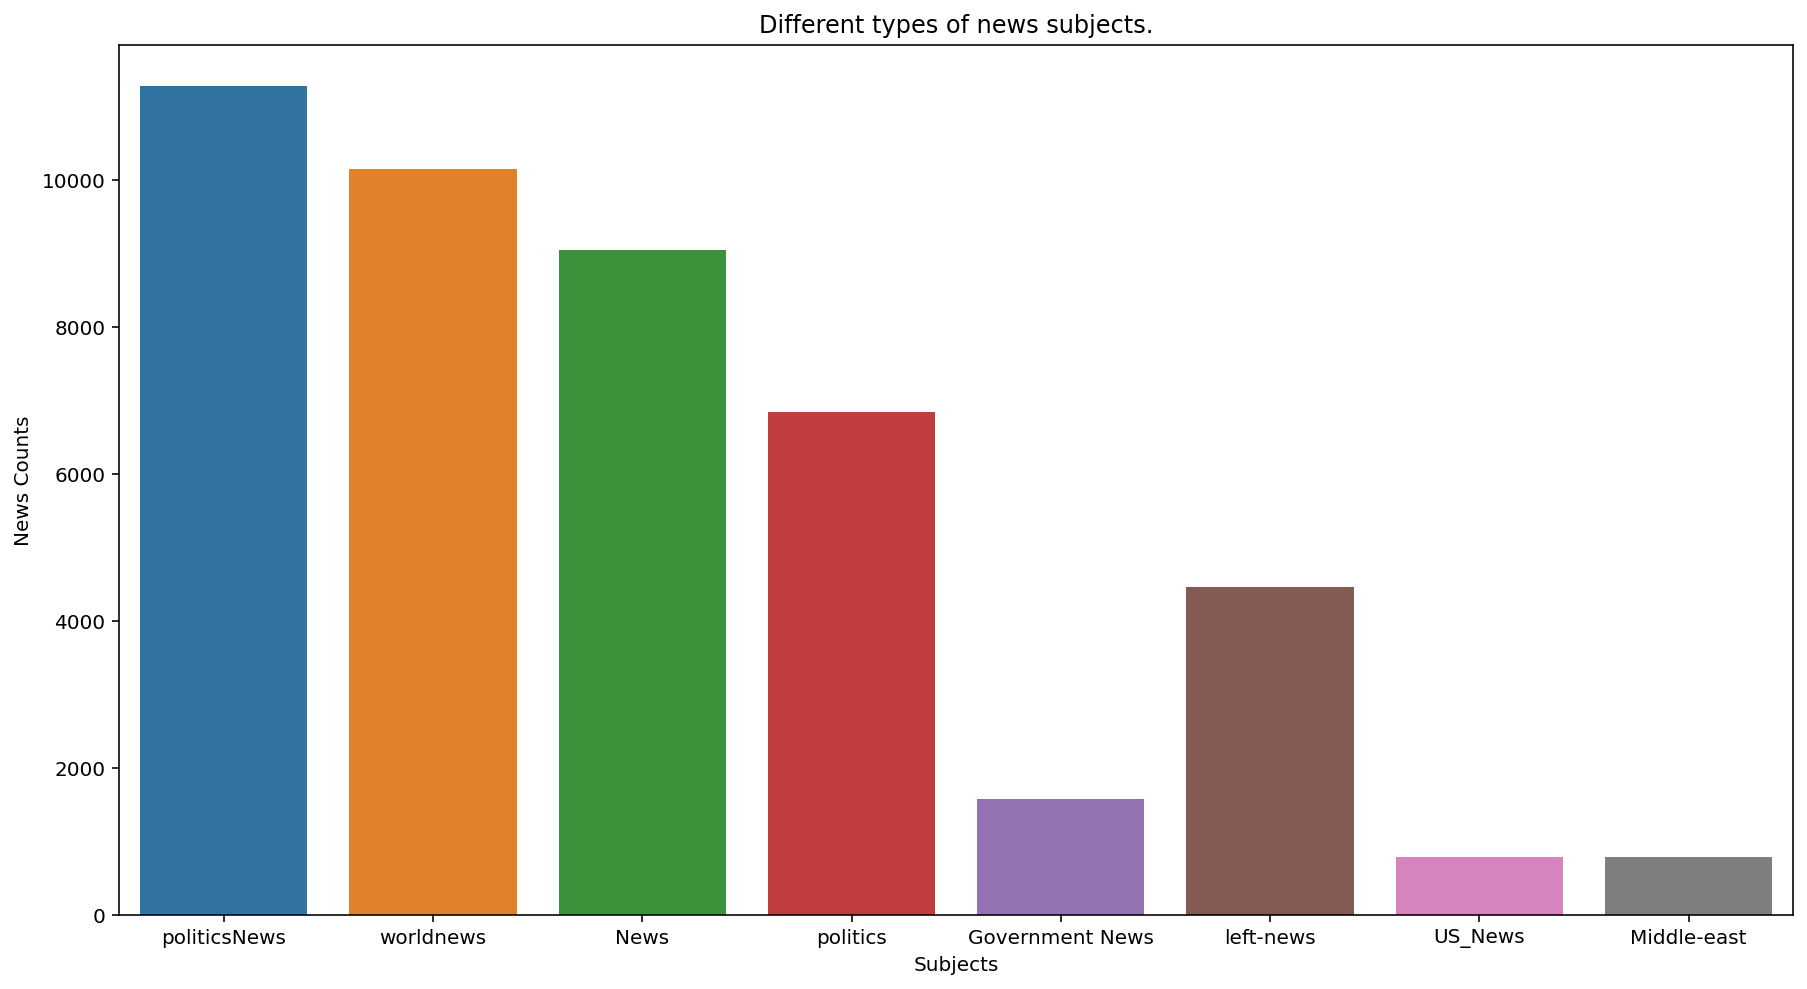

In [150]:
plt.figure(figsize=(15, 8))
sns.countplot(x="subject", data=news_df)
plt.title("Different types of news subjects.")
plt.xlabel("Subjects")
plt.ylabel("News Counts")
plt.show()

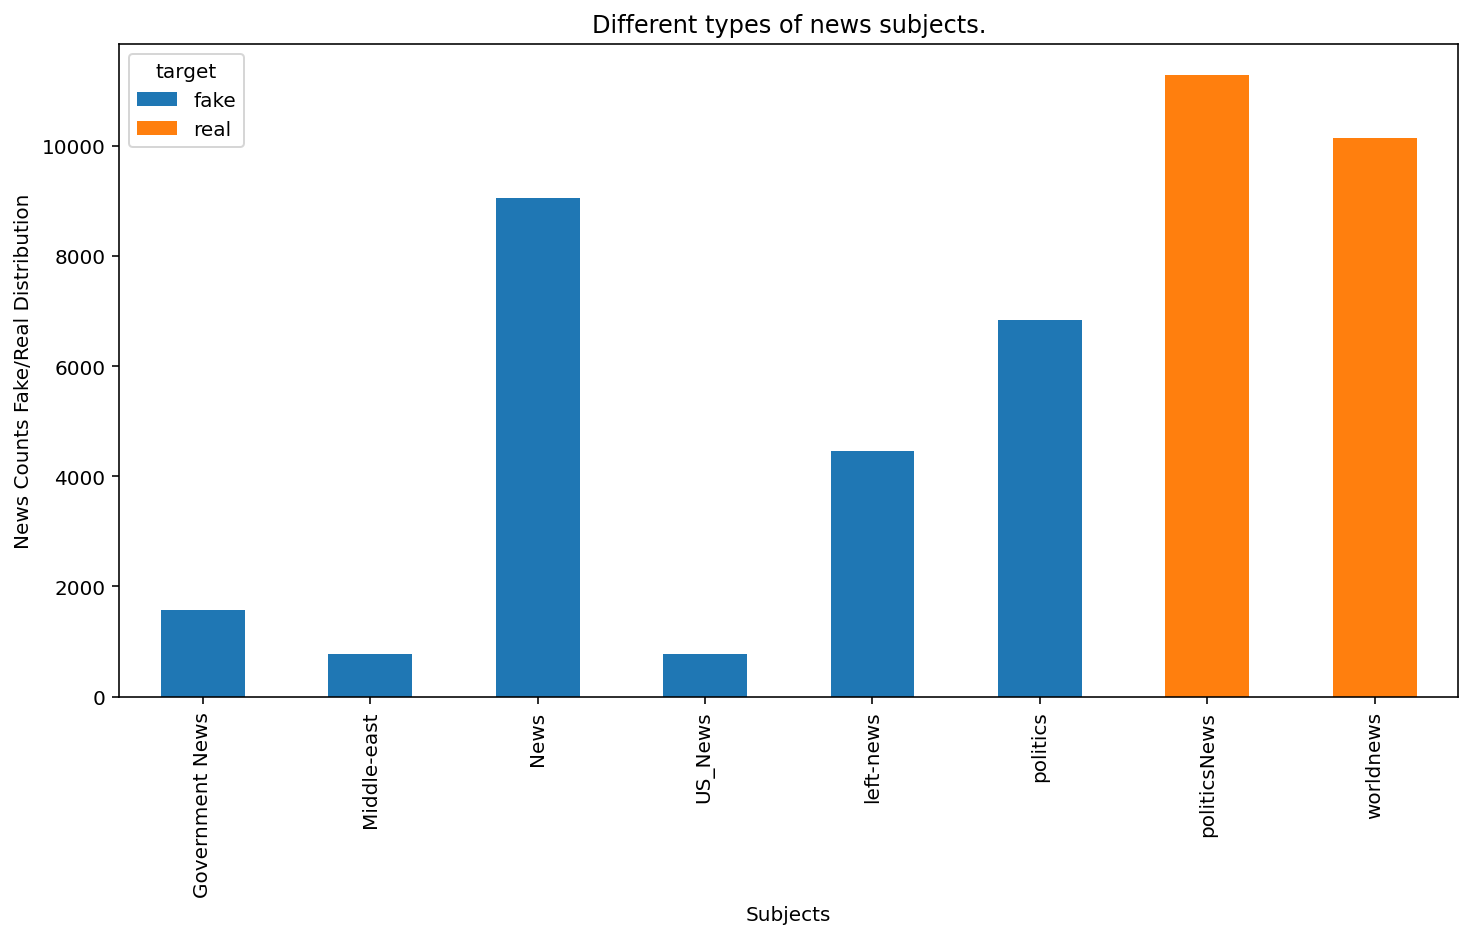

In [151]:
temp_df = news_df.groupby(['subject', 'target']).size().reset_index().pivot(columns='target', index='subject', values=0).fillna(0)
temp_df.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Different types of news subjects.")
plt.xlabel("Subjects")
plt.ylabel("News Counts Fake/Real Distribution")
plt.show()

> fake or real news does not have a uniform distribution among different news subjects. We can see that some news subjects are completely fake while others are completely real. We need to look into what kind of words make fake and real news. It also shows us that we should be careful while using news subjects as one of the features since it can make our model biased. 

____

#### date

In [152]:
news_df[news_df.date.str.len() > 19]

title  \
30775  https://100percentfedup.com/served-roy-moore-v...   
36924  https://100percentfedup.com/video-hillary-aske...   
36925  https://100percentfedup.com/12-yr-old-black-co...   
37256  https://fedup.wpengine.com/wp-content/uploads/...   
37257  https://fedup.wpengine.com/wp-content/uploads/...   
38849  https://fedup.wpengine.com/wp-content/uploads/...   
38850  https://fedup.wpengine.com/wp-content/uploads/...   
40350                                           Homepage   
43286  https://fedup.wpengine.com/wp-content/uploads/...   
43287  https://fedup.wpengine.com/wp-content/uploads/...   

                                                    text          subject  \
30775  https://100percentfedup.com/served-roy-moore-v...         politics   
36924  https://100percentfedup.com/video-hillary-aske...         politics   
36925  https://100percentfedup.com/12-yr-old-black-co...         politics   
37256  https://fedup.wpengine.com/wp-content/uploads/...         politics   
37257  https://fedup.wpengine.com/wp-content/uploads/...         politics   
38849  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
38850  https://fedup.wpengine.com/wp-content/uploads/...  Government News   
40350  [vc_row][vc_column width= 1/1 ][td_block_trend...        left-news   
43286  https://fedup.wpengine.com/wp-content/uploads/...        left-news   
43287  https://fedup.wpengine.com/wp-content/uploads/...        left-news   

                                                    date target  
30775  https://100percentfedup.com/served-roy-moore-v...   fake  
36924  https://100percentfedup.com/video-hillary-aske...   fake  
36925  https://100percentfedup.com/12-yr-old-black-co...   fake  
37256  https://fedup.wpengine.com/wp-content/uploads/...   fake  
37257  https://fedup.wpengine.com/wp-content/uploads/...   fake  
38849  https://fedup.wpengine.com/wp-content/uploads/...   fake  
38850  https://fedup.wpengine.com/wp-content/uploads/...   fake  
40350  MSNBC HOST Rudely Assumes Steel Worker Would N...   fake  
43286  https://fedup.wpengine.com/wp-content/uploads/...   fake  
43287  https://fedup.wpengine.com/wp-content/uploads/...   fake

> Just looking at the date column we found that date column might have irregularities. 

In [153]:
news_df.drop(news_df[news_df.date.str.len() > 19].index, inplace = True)

In [154]:
news_df['date'] = pd.to_datetime(news_df['date'])

Now, let's look at timelines for increase or decrease of real or fake news in our dataset 

In [155]:
daily_aggregated_counts = news_df.groupby(["date", 'target']).size().reset_index().sort_values(["date"])
daily_aggregated_counts.columns = ["date", "target", "count"]

In [156]:
daily_aggregated_counts.head(20)

date target  count
0  2015-03-31   fake      8
1  2015-04-01   fake      2
2  2015-04-02   fake      1
3  2015-04-04   fake      5
4  2015-04-05   fake     13
5  2015-04-06   fake     24
6  2015-04-07   fake     16
7  2015-04-08   fake     10
8  2015-04-09   fake     22
9  2015-04-10   fake     11
10 2015-04-11   fake      6
11 2015-04-12   fake     14
12 2015-04-13   fake     16
13 2015-04-14   fake     25
14 2015-04-15   fake      6
15 2015-04-16   fake     12
16 2015-04-17   fake     12
17 2015-04-18   fake      2
18 2015-04-19   fake      6
19 2015-04-20   fake     10

> By looking at the aggregated data, we observe that for year 2015, we don't have counts for real news. So, we will plot counts for rest of the data.  

Let's look at time series plots for daily aggregated counts for fake and real news. We are going to remove data for 2015 and 2018 since we have only fake news for those years. We will use rest of the data for analysis.  

In [157]:
_temp_daily_counts = daily_aggregated_counts[(daily_aggregated_counts.date.dt.year != 2018) & 
                  (daily_aggregated_counts.date.dt.year != 2015)]

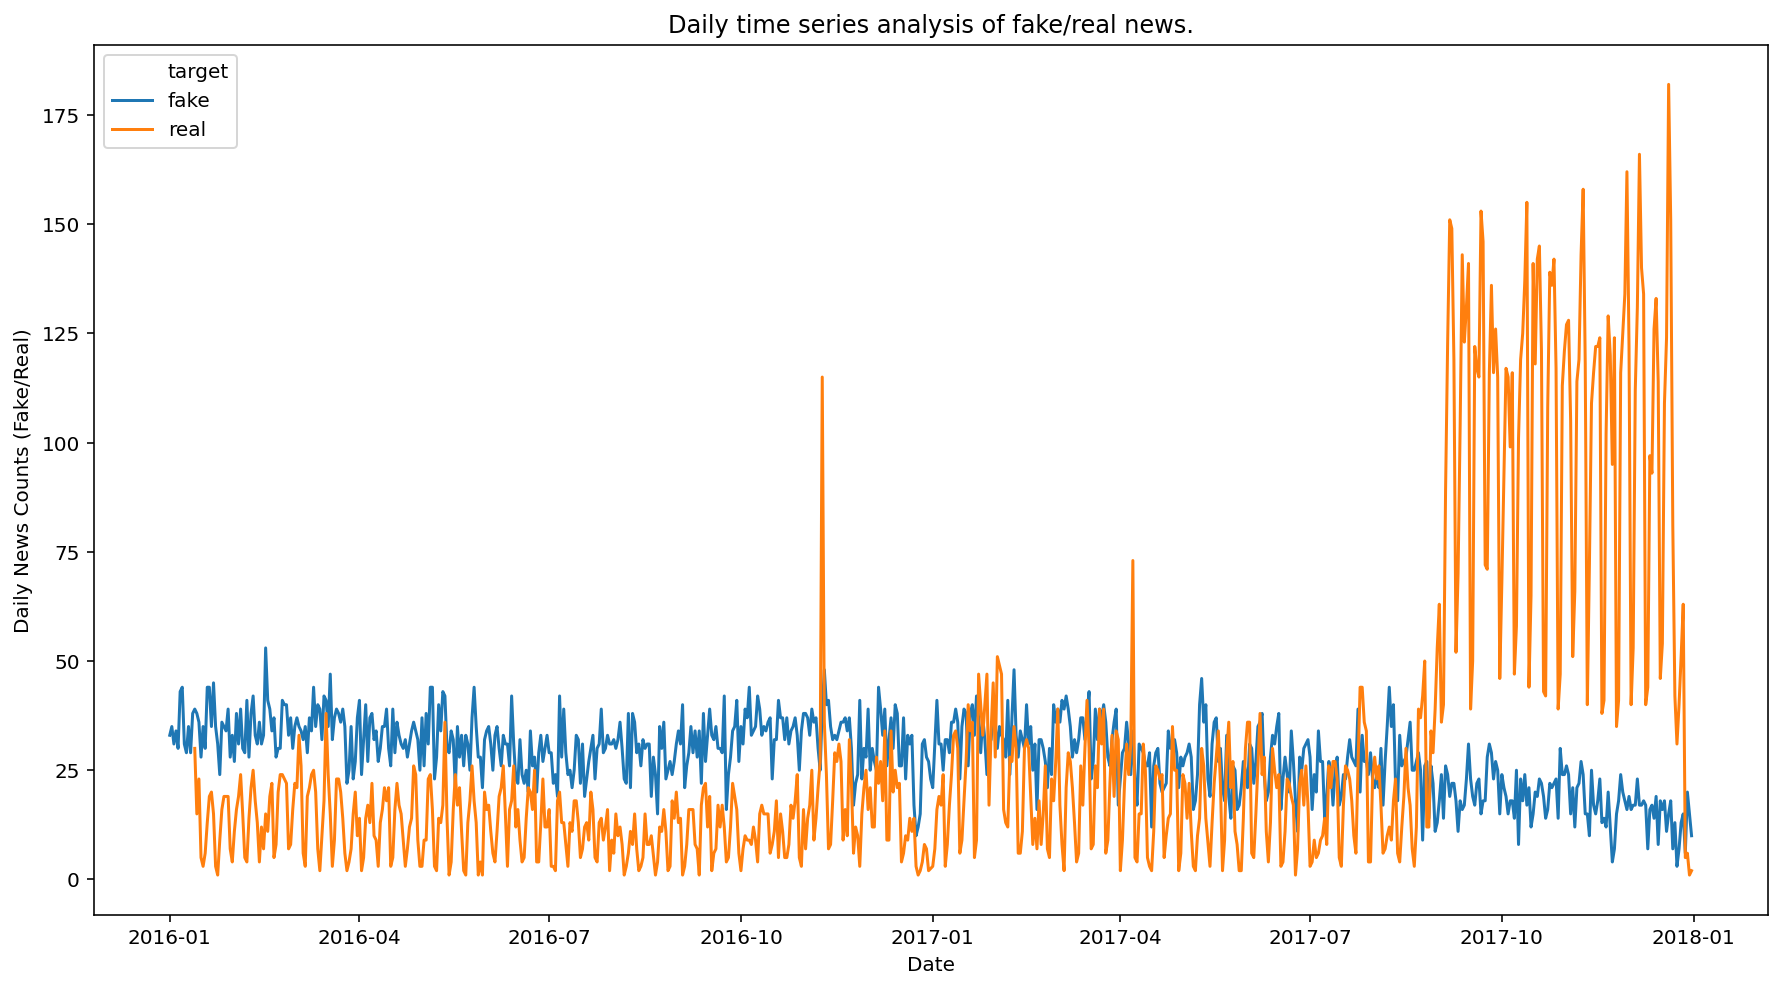

In [158]:
plt.figure(figsize=(15, 8))
sns.lineplot(x="date", y="count", data=_temp_daily_counts, hue="target")
plt.title("Daily time series analysis of fake/real news.")
plt.xlabel("Date")
plt.ylabel("Daily News Counts (Fake/Real)")
plt.show()

> Clearly, we can see that in the beginning of 2016 we had more fake news than real news. While on the other hand in the year 2018, we had a surge in real news. This also raises the questions on how this data was collected and also what were the factors that led to decrease/increase in fake news over the years.  

Let's see monthly aggregated counts of fake/real news and see the timeline

In [159]:
monthly_aggregated_counts = daily_aggregated_counts.groupby([daily_aggregated_counts.date.dt.to_period('M') , 'target']).sum().reset_index().sort_values(["date"])
monthly_aggregated_counts.columns = ["date", "target", "count"]

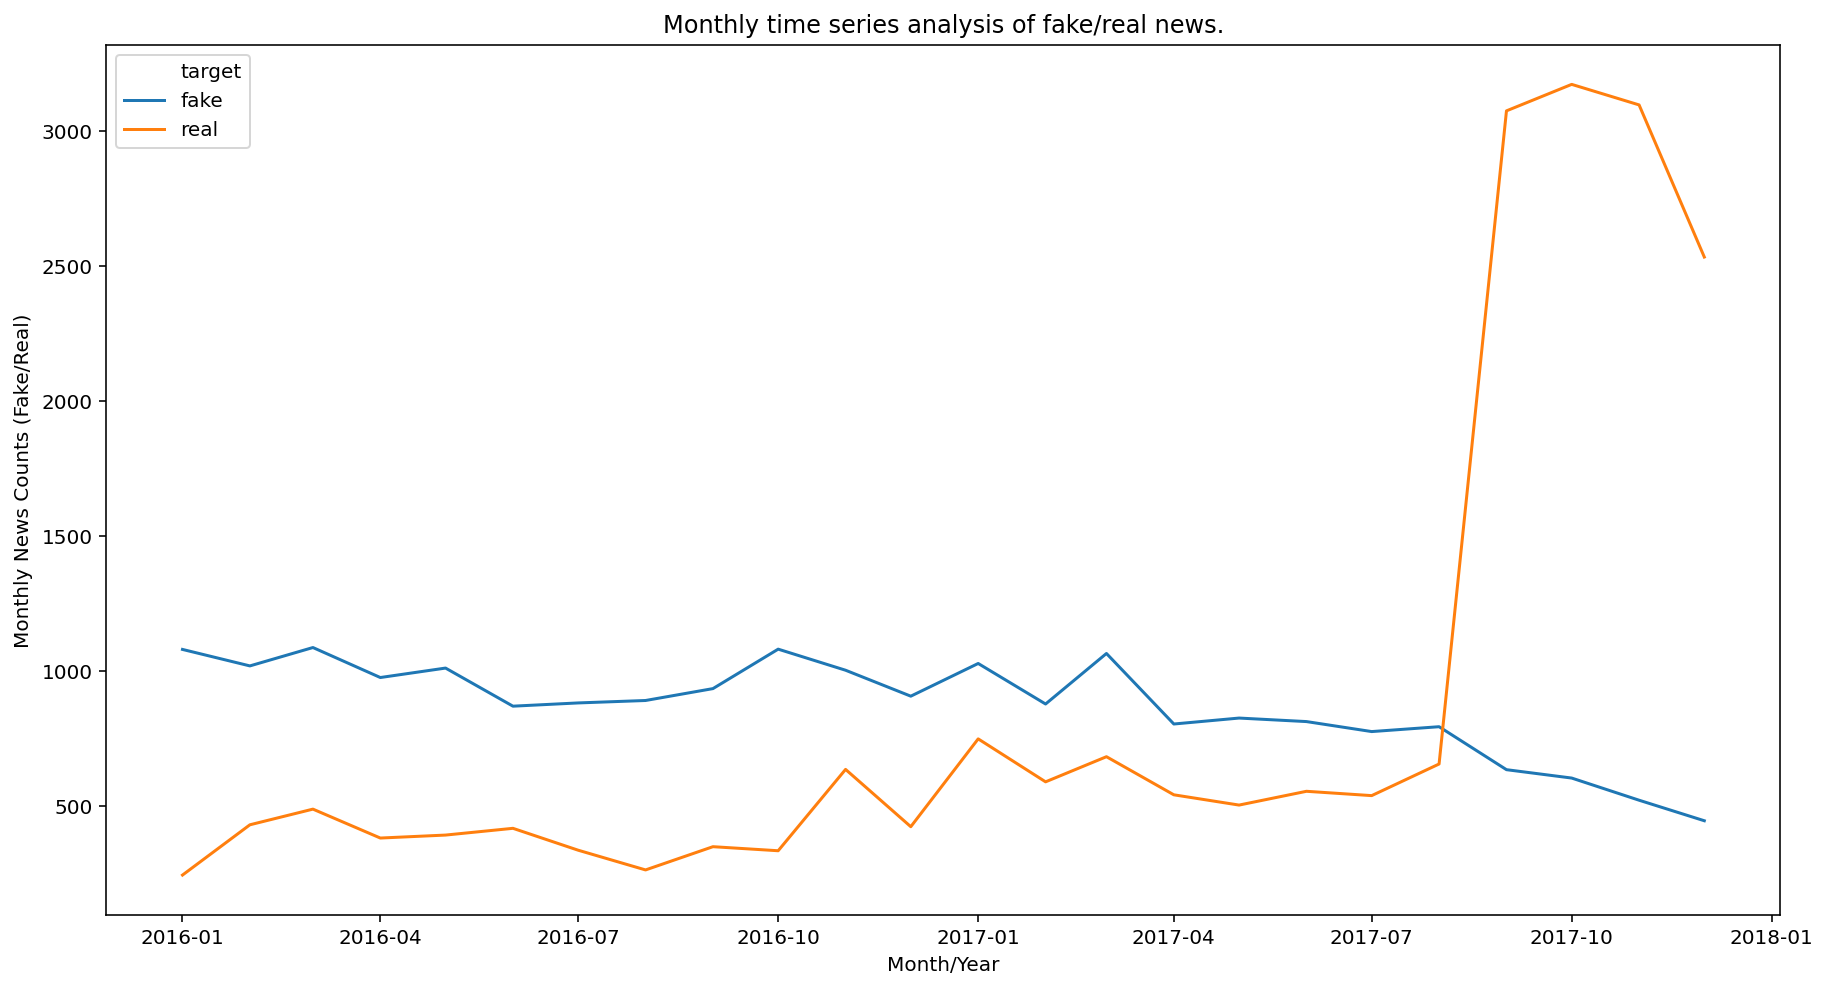

In [160]:
_temp_monthly_counts = monthly_aggregated_counts[(monthly_aggregated_counts.date.dt.year != 2018) & 
                  (monthly_aggregated_counts.date.dt.year != 2015)]

_temp_monthly_counts.loc[:, 'date'] = _temp_monthly_counts.date.values.astype('datetime64[M]')

plt.figure(figsize=(15, 8))
sns.lineplot(x="date", y="count", data=_temp_monthly_counts, hue="target")
plt.title("Monthly time series analysis of fake/real news.")
plt.xlabel("Month/Year")
plt.ylabel("Monthly News Counts (Fake/Real)")
plt.show()

> We see a rise in real news articles in August, 2017. I went online to research what was going on at this time in US. I found that there was a rise in fkae news discussion at various levels. Form the beginning of 2017, discussion s on how to combat fake news started. Twitter also started working on initiatives to stop fake and offensive news on there platform. 

1. https://www.nytimes.com/interactive/2017/business/media/trump-fake-news.html
2. https://blogs.lse.ac.uk/medialse/2017/08/10/the-evolving-conversation-around-fake-news-and-potential-solutions/
3. https://www.washingtonpost.com/news/the-switch/wp/2017/06/29/twitter-is-looking-for-ways-to-let-users-flag-fake-news/


Let's also check time series changes in fake /real news in terms of subject of news.

In [161]:
_monthly_subject_counts = news_df.groupby([news_df.date.dt.to_period('M'), 'subject', 'target']).size().reset_index().sort_values(["date"])
_monthly_subject_counts.columns = ["date", "subject", "target", "count"]

_monthly_subject_counts.loc[:, 'date'] = _monthly_subject_counts.date.values.astype('datetime64[M]')

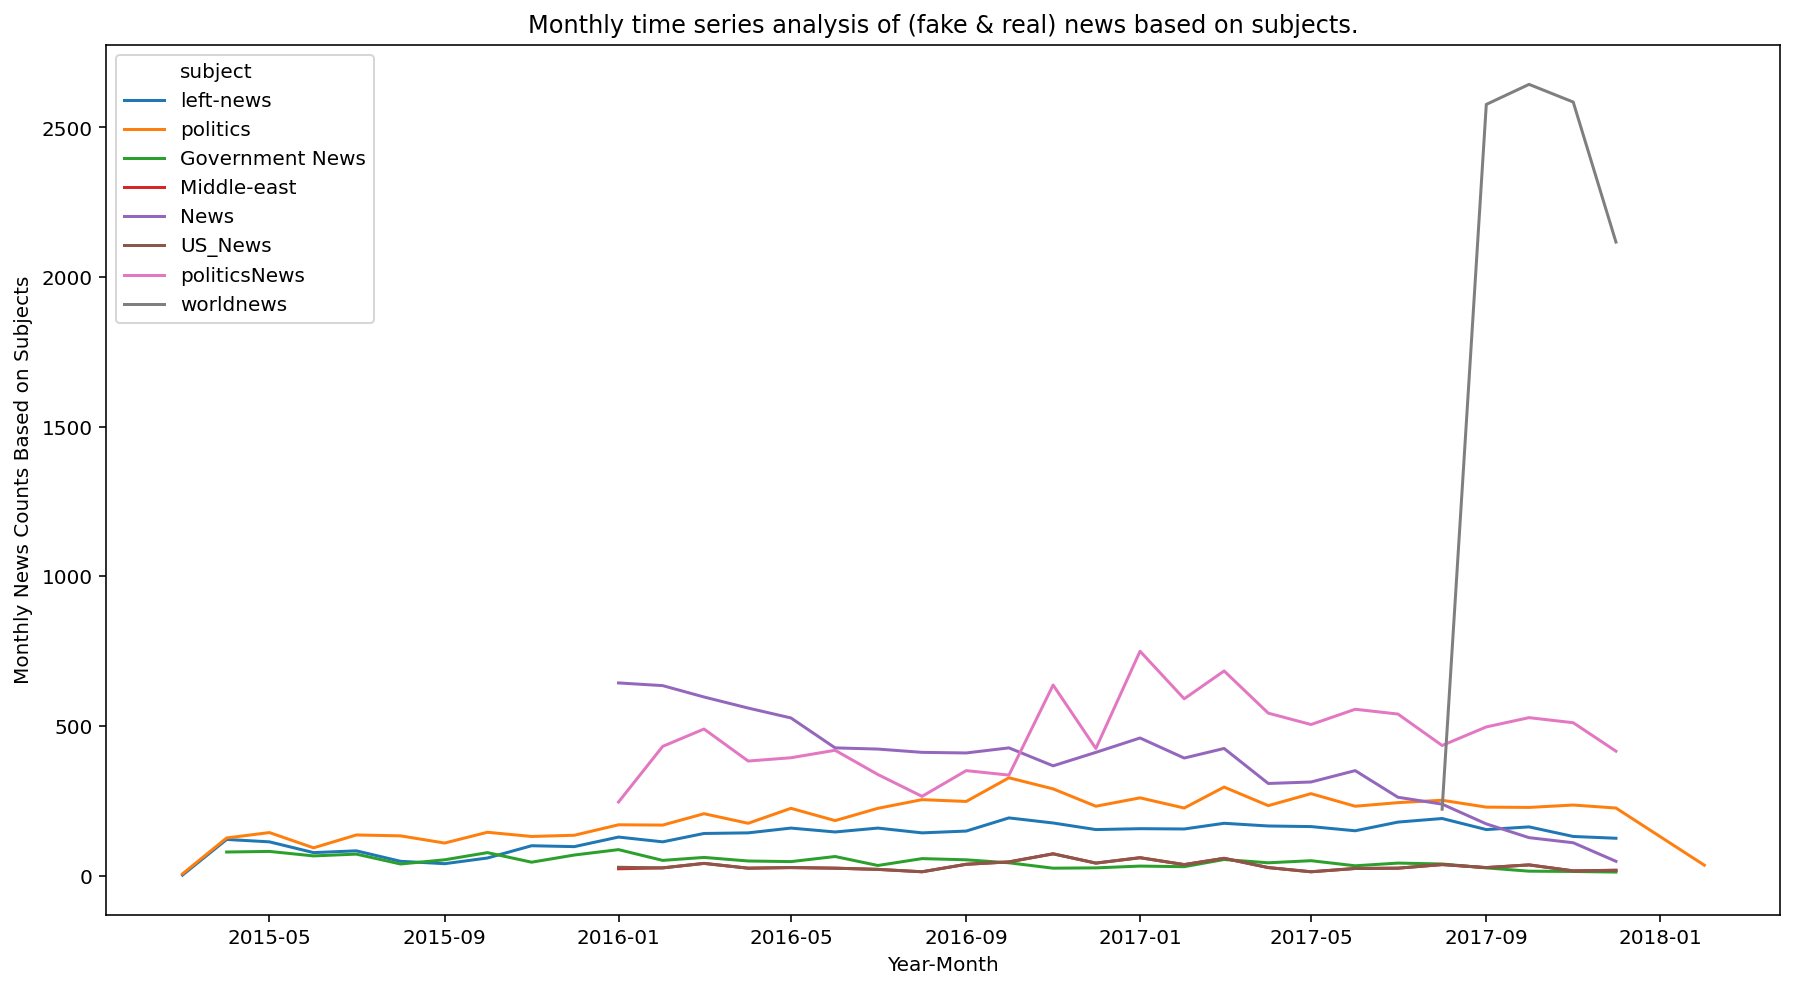

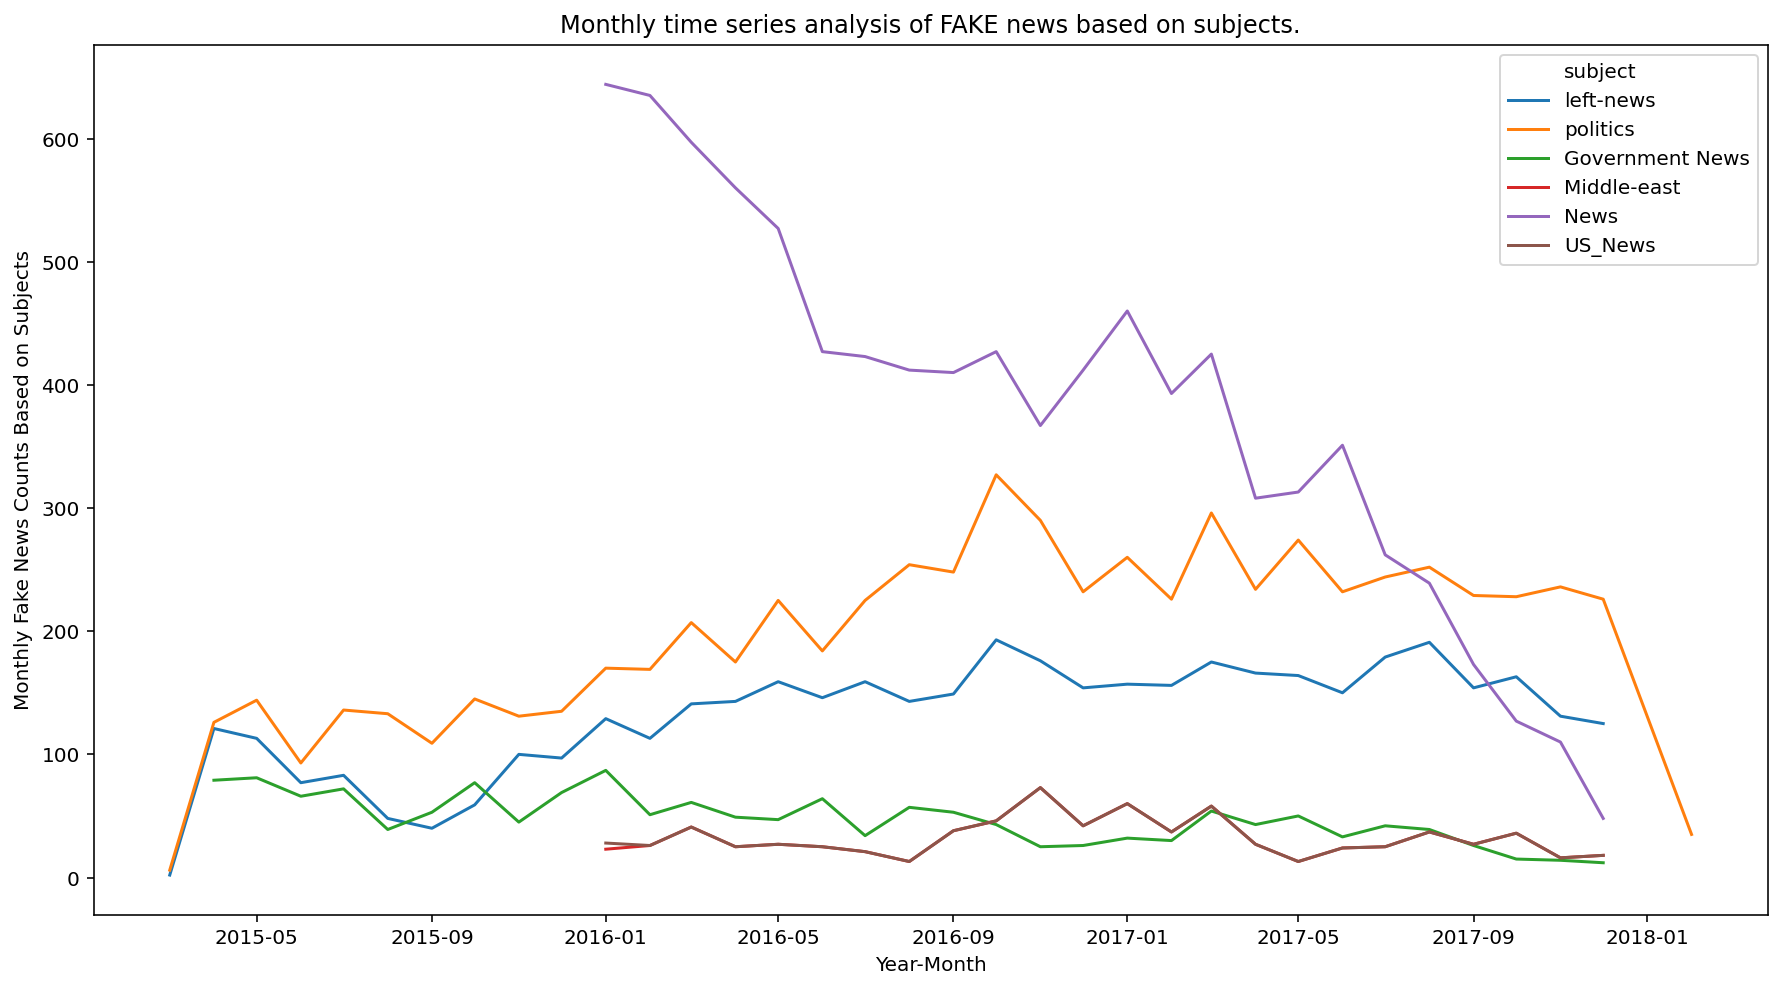

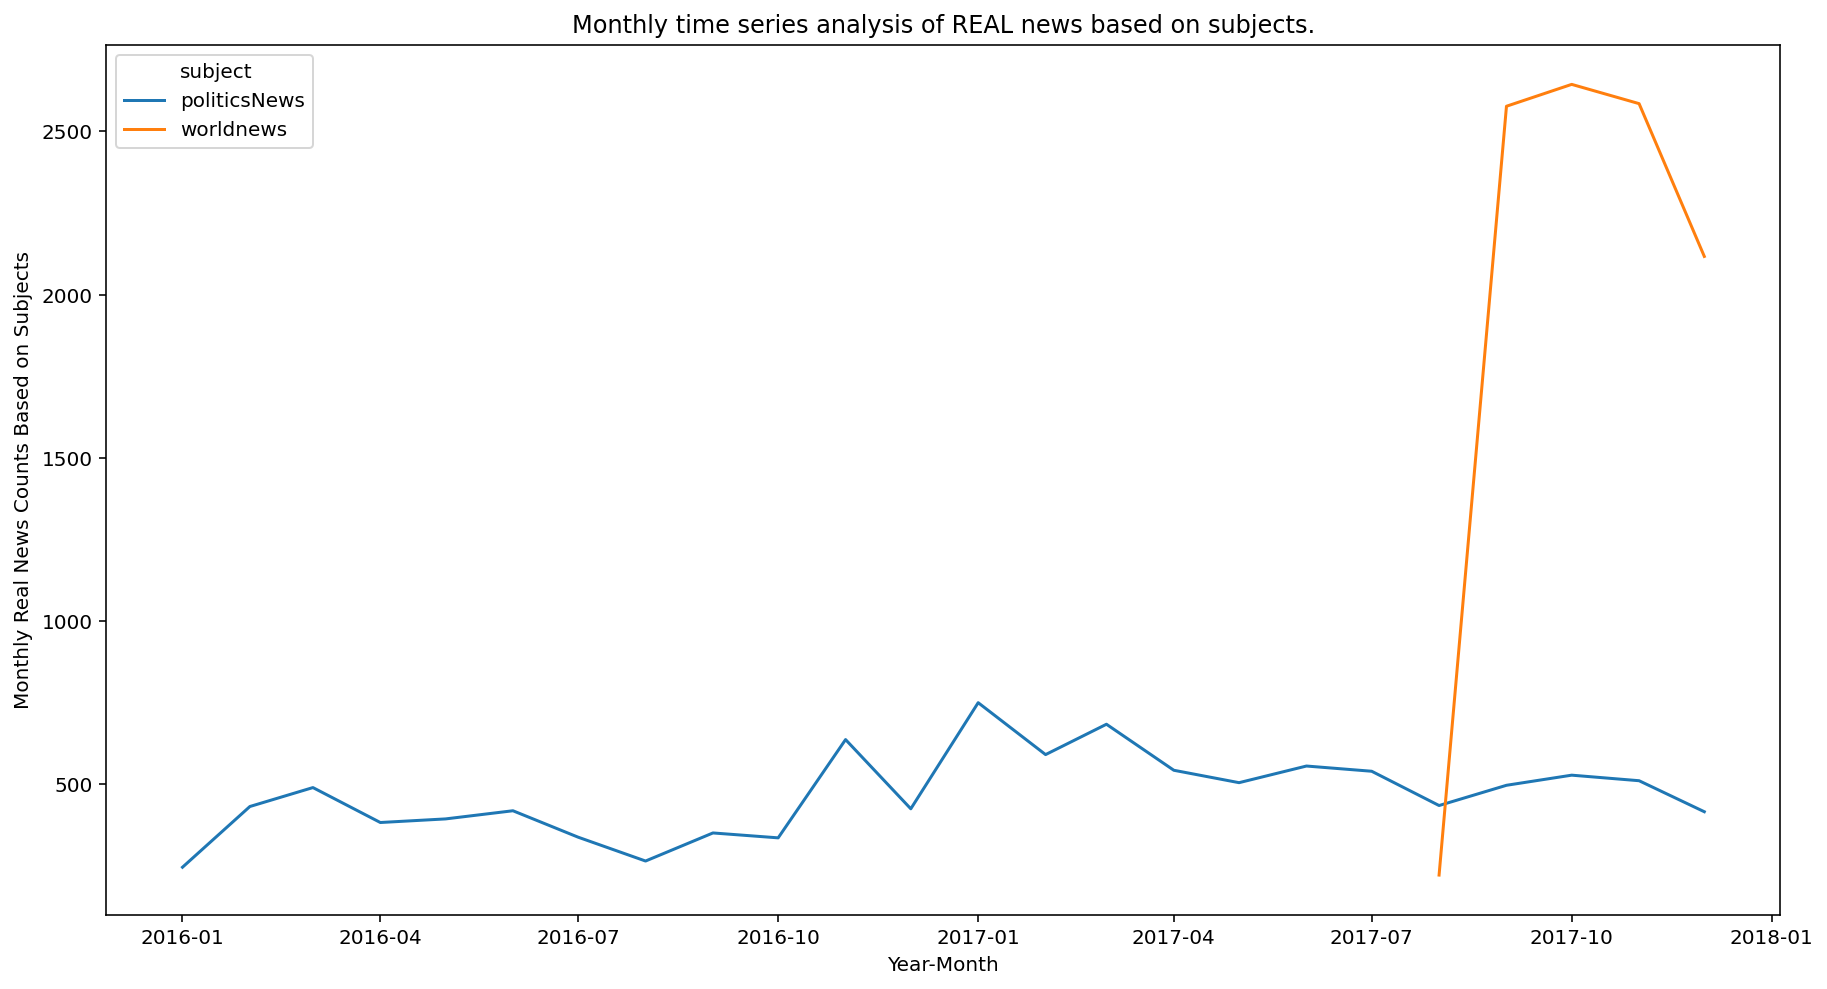

In [162]:


plt.figure(figsize=(15, 8))
sns.lineplot(x="date", y="count", data=_monthly_subject_counts, hue="subject")
plt.title("Monthly time series analysis of (fake & real) news based on subjects.")
plt.xlabel("Year-Month")
plt.ylabel("Monthly News Counts Based on Subjects")
plt.show()



_fake_subject = _monthly_subject_counts[_monthly_subject_counts.target=="fake"]

plt.figure(figsize=(15, 8))
sns.lineplot(x="date", y="count", data=_fake_subject, hue="subject")
plt.title("Monthly time series analysis of FAKE news based on subjects.")
plt.xlabel("Year-Month")
plt.ylabel("Monthly Fake News Counts Based on Subjects")
plt.show()



_real_subject = _monthly_subject_counts[_monthly_subject_counts.target=="real"]

plt.figure(figsize=(15, 8))
sns.lineplot(x="date", y="count", data=_real_subject, hue="subject")
plt.title("Monthly time series analysis of REAL news based on subjects.")
plt.xlabel("Year-Month")
plt.ylabel("Monthly Real News Counts Based on Subjects")
plt.show()

> In the above time series analysis we have seen that some subjects don't exist in real news while other don't exist in fake news. This raises the question of how the data was collected and if we build a model on this data it might not generalize well on real world data. But let's look at the text data which forms the news, this might help us is building some features to build a model. 

____

Now, let's look at the columns for news **title** and news **text**. In order to analyse the text columns, we might need a few functions to clean data and create word counts columns in our dataframe.  

In [163]:
news_df[news_df.target == "real"].text[1]

'WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after President Donald Trump’s administration decided not to appeal rulings that blocked his transgender ban. Two federal appeals courts, one in Washington and one in Virginia, last week rejected the administration’s request to put on hold orders by lower court judges requiring the military to begin accepting transgender recruits on Jan. 1. A Justice Department official said the administration will not challenge those rulings. “The Department of Defense has announced that it will be releasing an independent study of these issues in the coming weeks. So rather than litigate this interim appeal before that occurs, the administration has decided to wait for DOD’s study and will continue to defend the president’s lawful authority in District Court in the meantime,” the official said, speaking on condition 

In [164]:
news_df[news_df.target == "fake"].text[21417]

'Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t ev

> Just by looking at the text we can see that fake news has a lot of @(twitter_handle). So, this is something we should look into for further analysis. 

In [165]:
def countTwitterUsers(row):
    _user_handles_regex = re.compile(r'@([A-Za-z0-9_]+)')
    return len(re.findall(_user_handles_regex, row))

In [166]:
news_df.loc[:, "total_twitter_handles"] = news_df.apply(lambda x: countTwitterUsers(x["text"]), axis=1)

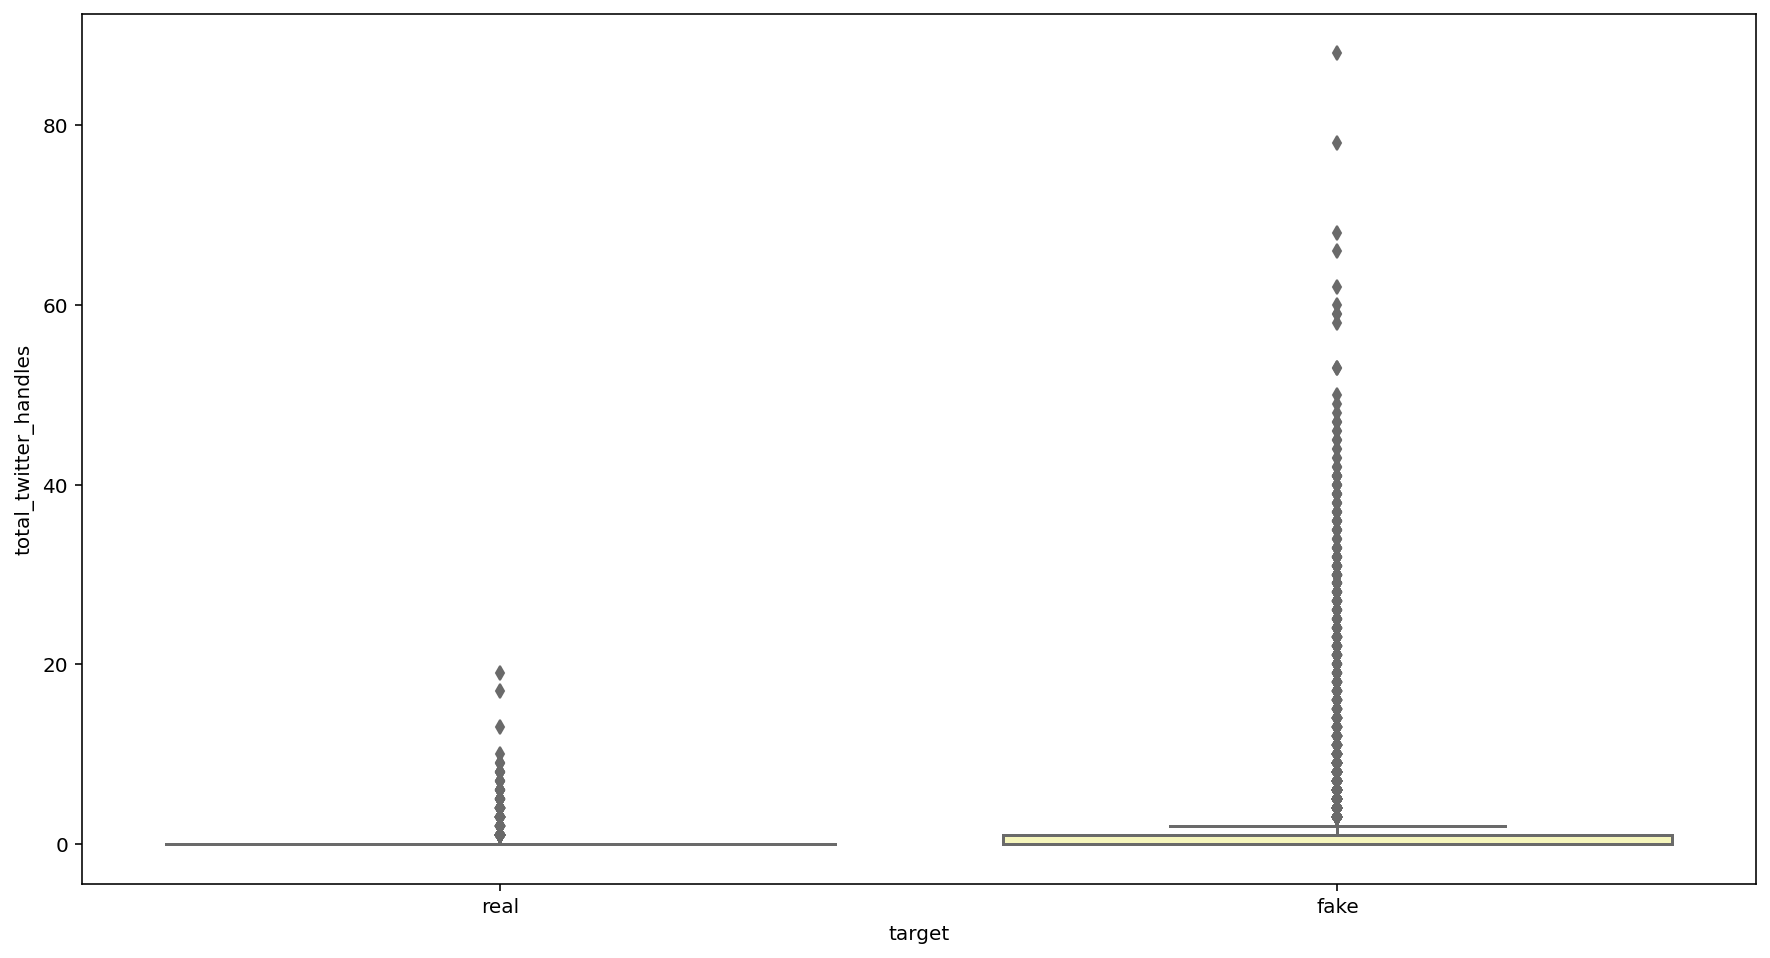

In [167]:
plt.figure(figsize=(15, 8))
ax = sns.boxplot(x="target", y="total_twitter_handles",
                 data=news_df, palette="Set3"
                )
plt.show()

In [168]:
print("Statistics on number of twitter handles in fake news")
news_df[news_df.target == "fake"].total_twitter_handles.describe()


Statistics on number of twitter handles in fake news


count    23471.000000
mean         1.188104
std          4.145195
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         88.000000
Name: total_twitter_handles, dtype: float64

In [169]:
print("Statistics on number of twitter handles in real news")
news_df[news_df.target == "real"].total_twitter_handles.describe()

Statistics on number of twitter handles in real news


count    21417.000000
mean         0.037494
std          0.423052
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.000000
Name: total_twitter_handles, dtype: float64

> Looking, at boxplot for real news we can say that most of real news does not have any twitter handles in it. Fake news is more spread as compared to real news in terms of tiwtter handles used. We have a lot of outliers in both fake and real news when it comes to number of twitter handles used. The number of twitter handles mentioned in fake news are much higher than real news. This might be also because of sources of data collection for fake and real news. Looks like fake news data was collected from twitter while real news data was collected from other news sources. 

Let's look at some other stats like number of words, number of unique words and number of real dictionary words in fake/real news data.

In [170]:
def countUniqueWords(row, col_name):
    return len(set(row[col_name].strip(' ').split()))

In [171]:
def countWords(row, col_name):
    return len(row[col_name].strip(' ').split())

Now, lets move on to cleaning text data and look into words statistics for fake & real news. 

In [172]:
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [173]:
#words = set(nltk.corpus.words.words())

In [174]:
def cleanData(row, column_name):
    text = row[column_name]
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = [word.strip().lower() for word in text.split() if word.strip().lower() not in stop_words 
            and word.strip().lower().isalpha()]
    #text = [word for word in text if word in words]
    text = " ".join(text)
    text = re.sub(r'[?|$|.|!,()]',r'',text)
    return text

Let's lemmatize our data to reduce inflection in words and map a group of words to same stem, which generalizes our dataset.

In [175]:
def lemmatizeNewsText(row, column):
    wordnet_lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(row[column])
    lemmatize_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in token_words])
    return lemmatize_text

In [176]:
#wordnet_lemmatizer = WordNetLemmatizer()
#wordnet_lemmatizer.lemmatize("have")

In [177]:
news_df.loc[:, "clean_data"] = news_df.apply(lambda x: cleanData(x, "text"), axis=1)
news_df.loc[:, "lemmatize_data"] = news_df.apply(lambda x: lemmatizeNewsText(x, "clean_data"), axis=1)
news_df.loc[:, "unique_words"] = news_df.apply(lambda x: countUniqueWords(x, "lemmatize_data"), axis=1)
news_df.loc[:, "total_words"] = news_df.apply(lambda x: countWords(x, "lemmatize_data"), axis=1)

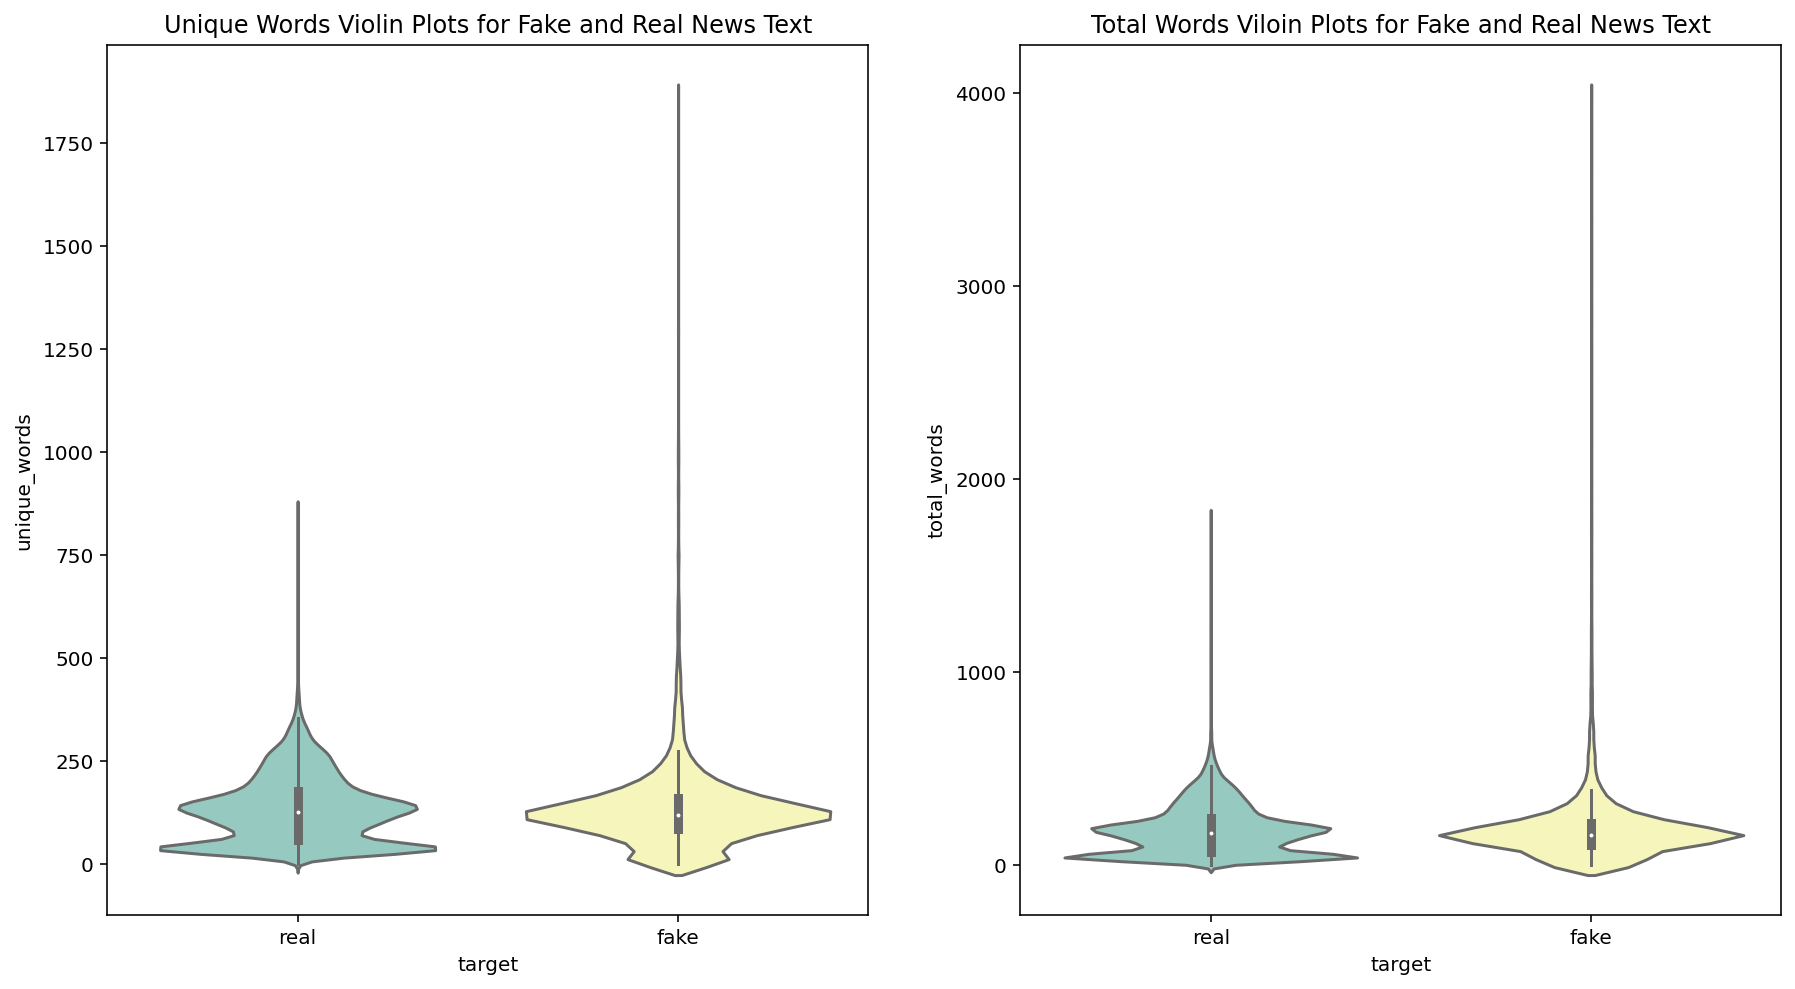

In [178]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
ax1 = sns.violinplot(x="target", y="unique_words",
                 data=news_df, palette="Set3",
                ax=axs[0])
ax2 = sns.violinplot(x="target", y="total_words",
                 data=news_df, palette="Set3",
                ax=axs[1])

ax1.title.set_text('Unique Words Violin Plots for Fake and Real News Text')
ax2.title.set_text('Total Words Viloin Plots for Fake and Real News Text')

plt.show()



In [179]:
print("Statistics on number of total words used in fake news")
news_df[news_df.target == "fake"].total_words.describe()


Statistics on number of total words used in fake news


count    23471.000000
mean       186.917345
std        186.872751
min          0.000000
25%        107.000000
50%        159.000000
75%        221.000000
max       3993.000000
Name: total_words, dtype: float64

In [180]:
print("Statistics on number of total words used in real news")
news_df[news_df.target == "real"].total_words.describe()

Statistics on number of total words used in real news


count    21417.000000
mean       182.789887
std        127.146998
min          0.000000
25%         71.000000
50%        170.000000
75%        248.000000
max       1806.000000
Name: total_words, dtype: float64

> Analyzing violin plots for unique words counts and word counts in our text column: 
1. The maximum number of total words used in fake news are much higher than the maximum number of total words in real news. 
2. Median for both kind of news is quite close. 
3. There are a lot more outliers (total words in text) in fake news as compared to real news. 
4. Outliers of fake news are on much more extreme end as compared to real news data. 
5. We also have 0 value for number of words in our news text which shows that we will need to clean some of this data. 
6. Fake news is much more spread out as compared to real news.

**IMP: While analyzing datasets ask these questions around the data so that it can be communicated to the customer, before building the model.** 

Looking at the violin plots, raises the question that why fake news has more words as compared to real news. Is this the correct repsentation of real world data. This data was downloaded from Kaggle, it can be hard question to answer: since most of the times data is collected by individuals and such questions go unanswered.

We also need to make sure that we remove the data which contains 0 words in text before building a model. 

Now, lets clean the data where we don't have any data in the news text column

In [181]:
news_df = news_df.drop((news_df[news_df.total_words == 0].index) | (news_df[news_df.unique_words == 0].index)).reset_index(drop=True)

Let's analyze the words that make up fake and real news. 

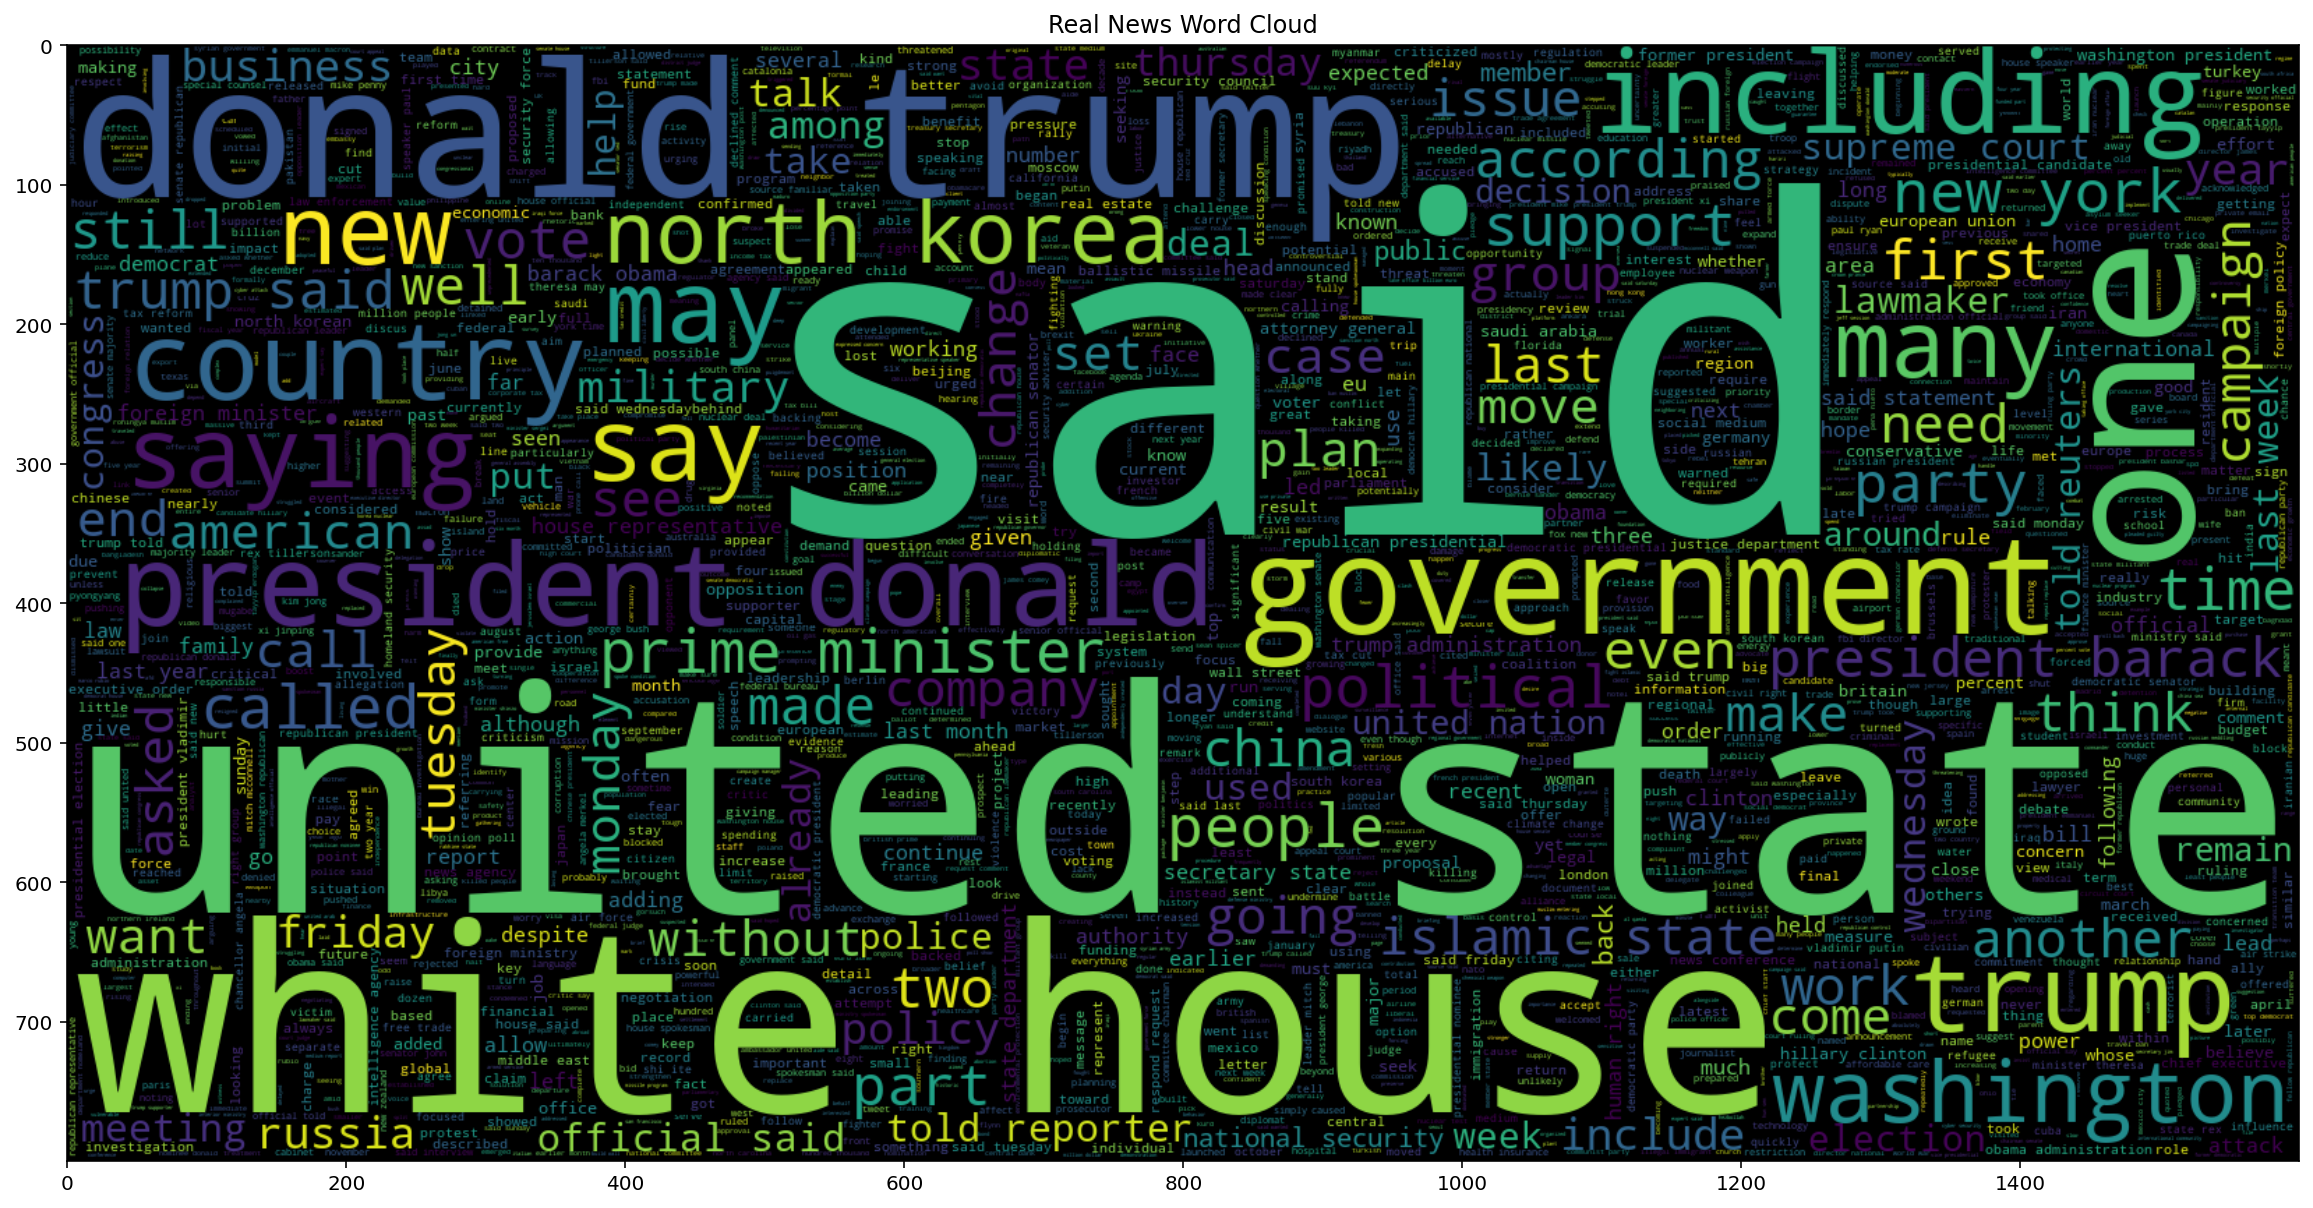

In [182]:
plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(news_df[news_df.target == "real"].lemmatize_data))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Real News Word Cloud")
plt.show()

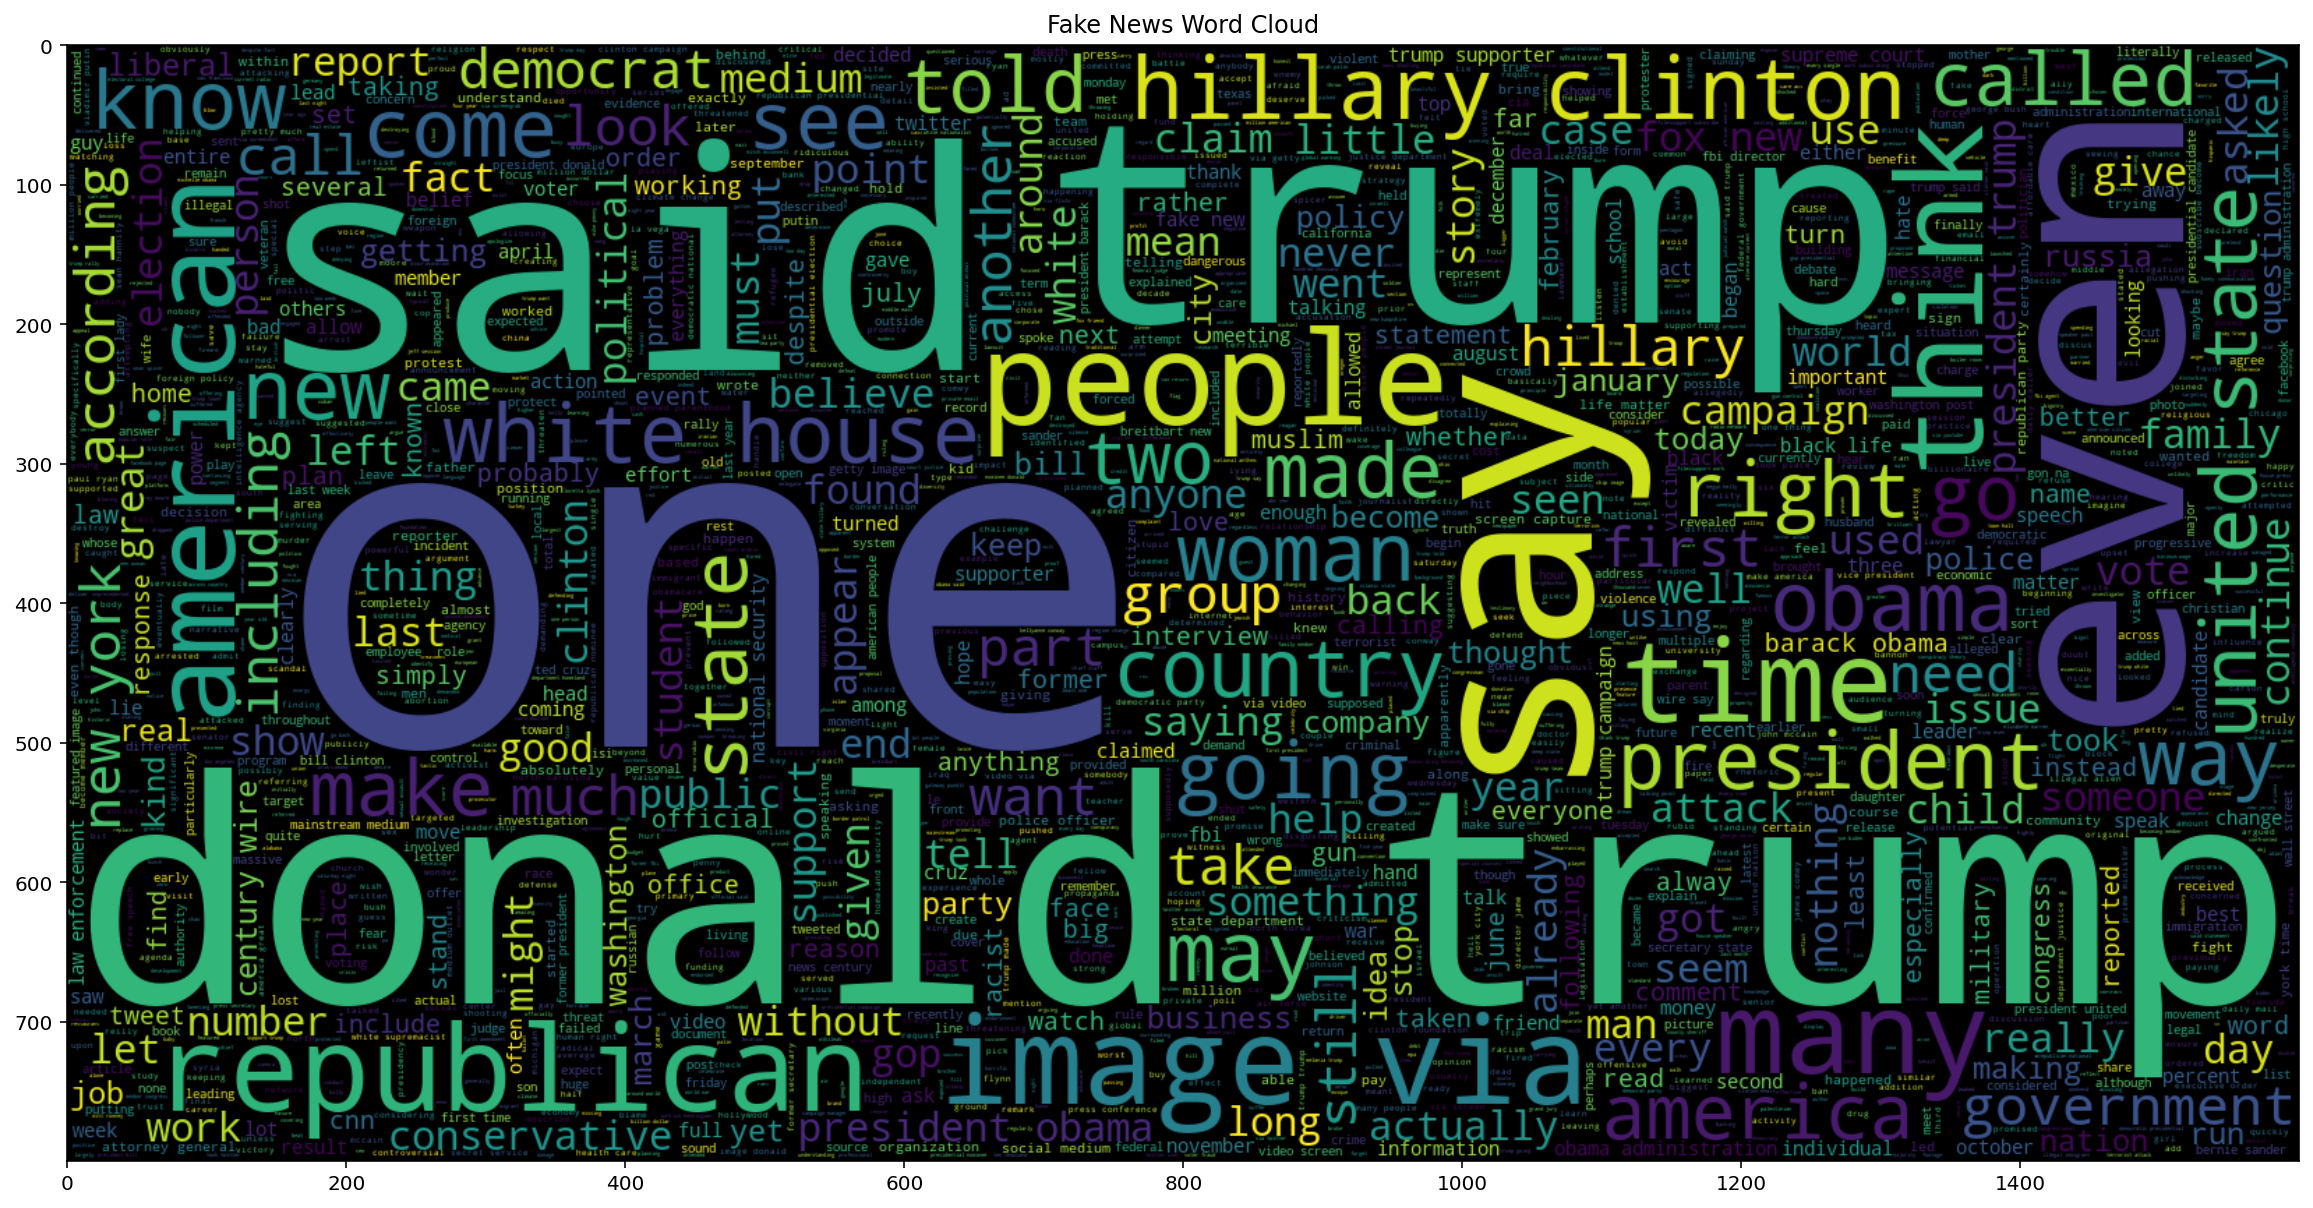

In [183]:
plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(news_df[news_df.target == "fake"].lemmatize_data))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Fake News Word Cloud")
plt.show()

> Looking at the words in the word clouds for fake and real news: the words seems to be quite similar in the news. 

In [184]:
import itertools

def getWordCorpus(df, column):
    words = list(itertools.chain.from_iterable([sentence.split() for sentence in df[column]]))
    return words


In [185]:
real_corpus = getWordCorpus(news_df[news_df.target == "real"], "lemmatize_data")
fake_corpus = getWordCorpus(news_df[news_df.target == "fake"], "lemmatize_data")

In [186]:
len(real_corpus)
len(fake_corpus)

4387137

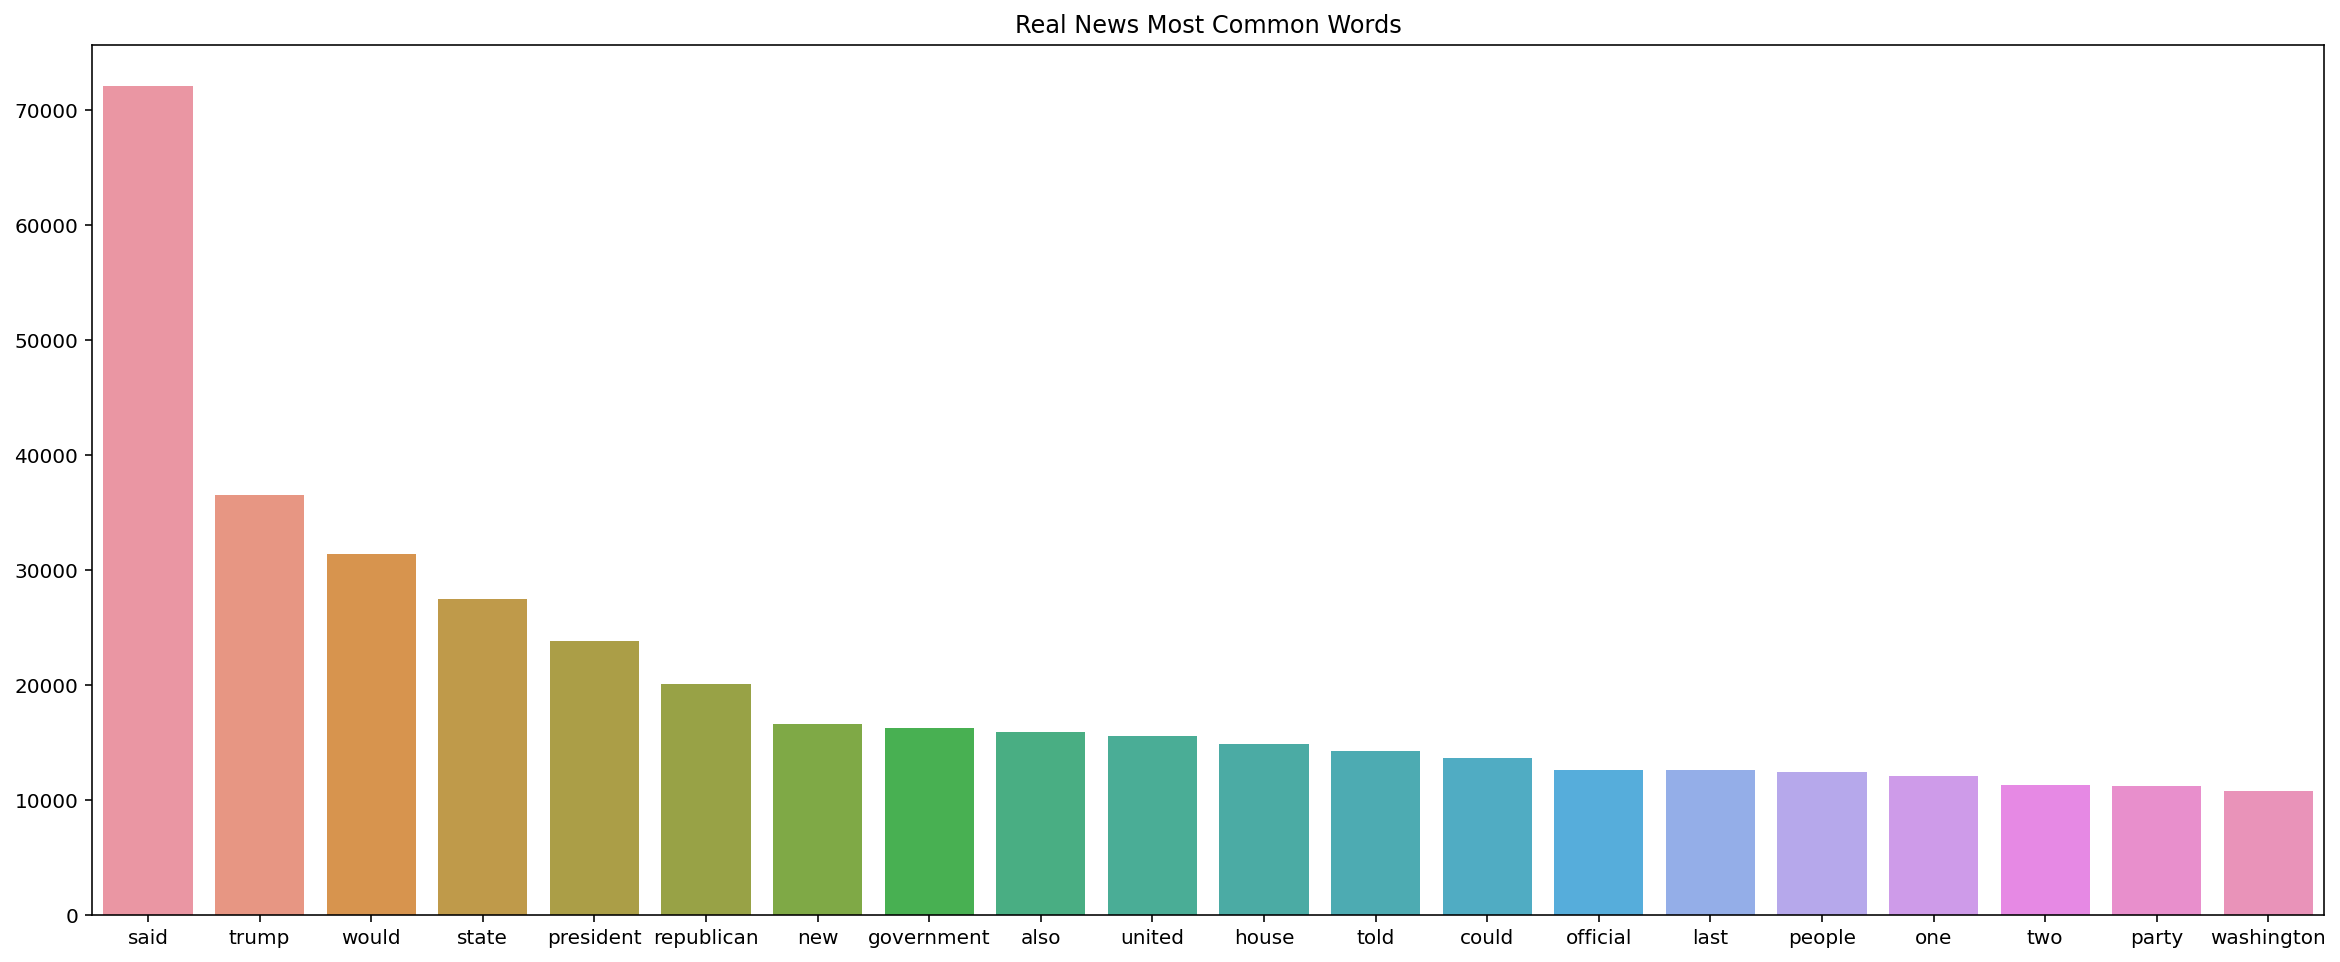

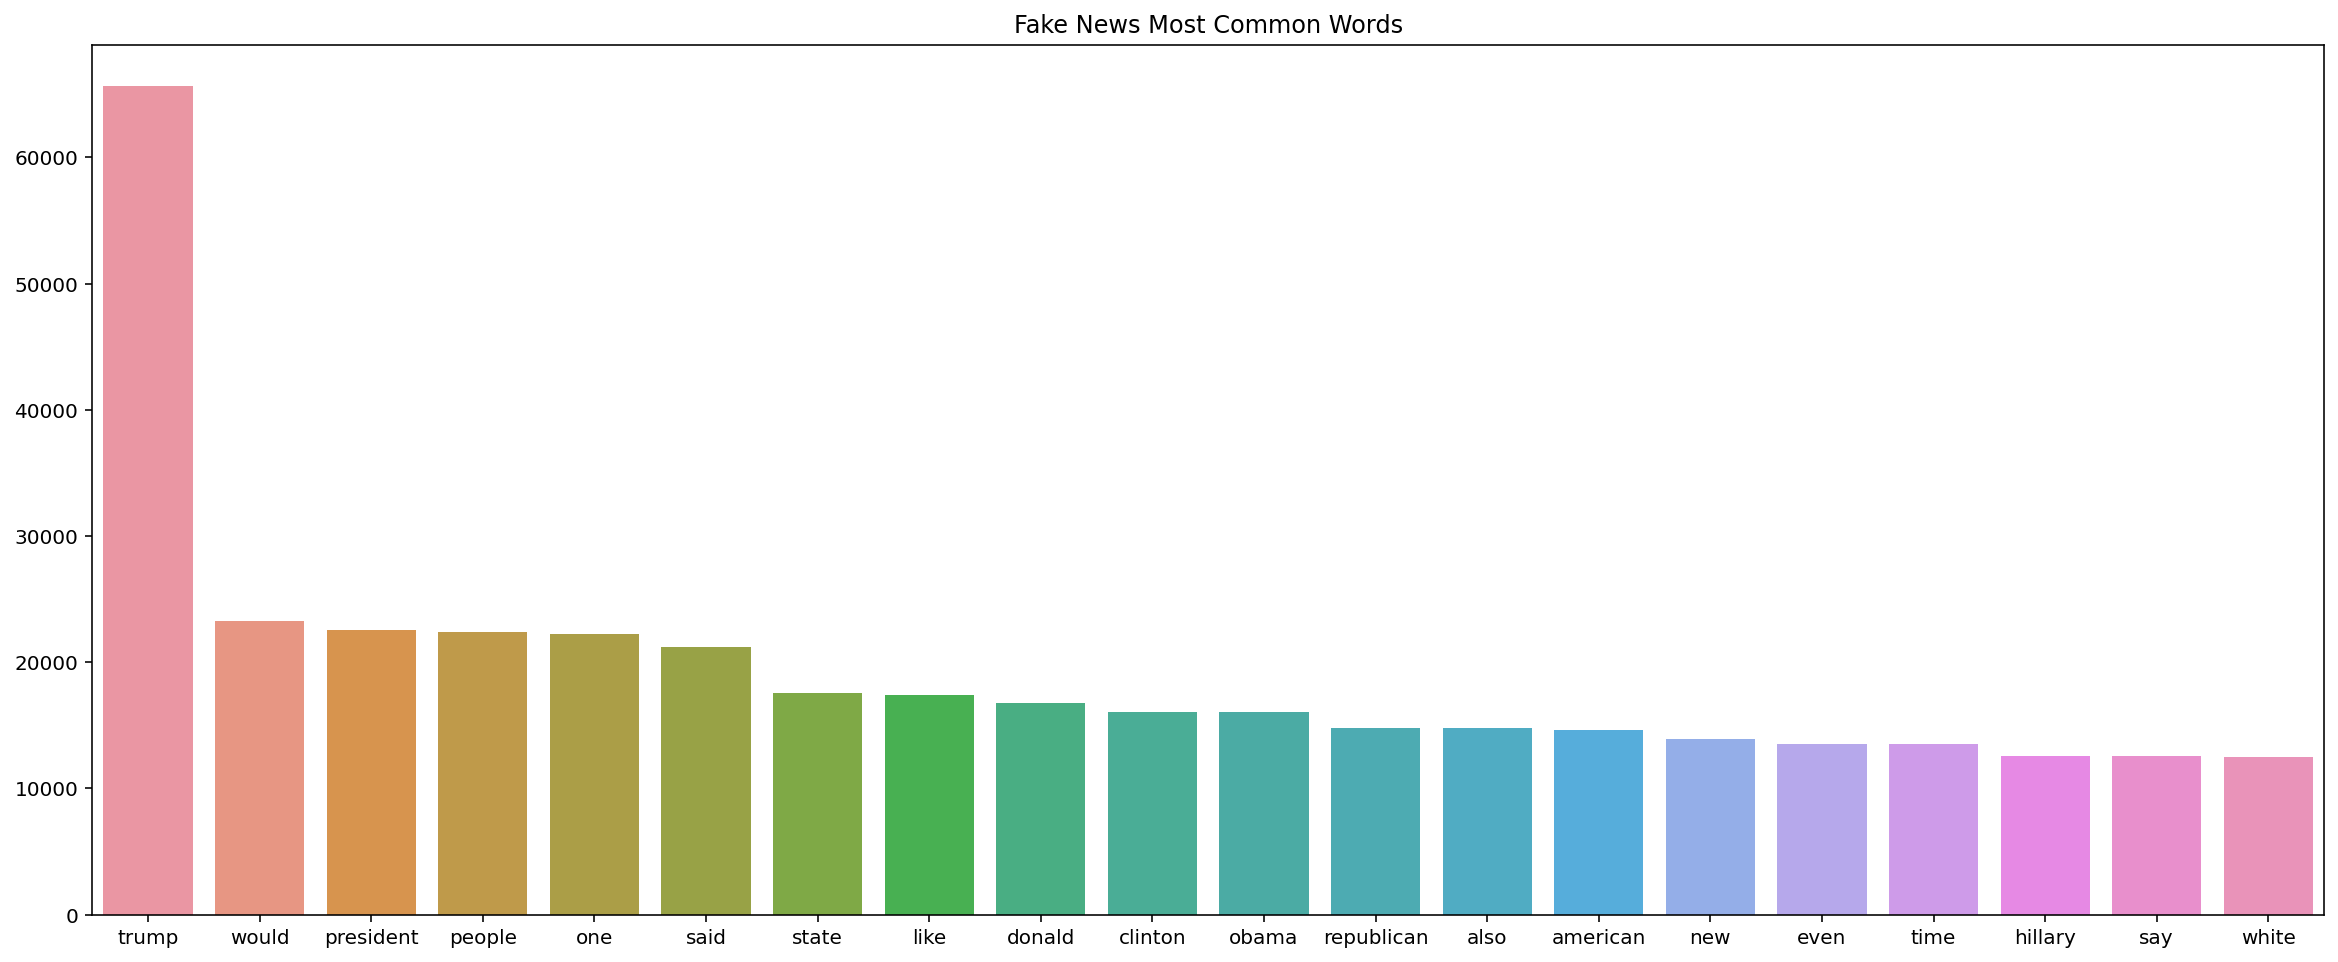

In [187]:
from collections import Counter

real_counter = Counter(real_corpus)
real_most_common = real_counter.most_common(20)
real_most_common = dict(real_most_common)

plt.figure(figsize = (20,8)) 
sns.barplot(x=list(real_most_common.keys()), y=list(real_most_common.values()))
plt.title("Real News Most Common Words")
plt.show()

fake_counter = Counter(fake_corpus)
fake_most_common = fake_counter.most_common(20)
fake_most_common = dict(fake_most_common)

plt.figure(figsize = (20,8)) 
sns.barplot(x=list(fake_most_common.keys()), y=list(fake_most_common.values()))
plt.title("Fake News Most Common Words")
plt.show()

> Looking at the most common words that occur in fake and real news. These words are quite similar to each other. This looks like something that would happen in real world where some words will be used in fake news (like donald, trump, clinton, obama etc.) as well as in real news (like donald, trump, republican, offical etc.) to provide clarity for fake news spread by people. 

Let's look at the chi2 value for the words in news data to find the impact of these words 

In [188]:
news_df["target"] = news_df["target"].astype('category')
news_df["target_category"] = news_df["target"].cat.codes

In [189]:
vectorizer = CountVectorizer()
_vec = vectorizer.fit_transform(news_df['lemmatize_data'])
_real_chi2_scores = chi2(_vec, news_df.target_category)[0]

In [190]:
chi2_scores_features = dict(zip(vectorizer.get_feature_names(), _real_chi2_scores))

In [191]:
sorted_chi2_scores = {k: v for k, v in sorted(chi2_scores_features.items(), key=lambda item: item[1], reverse=True)}

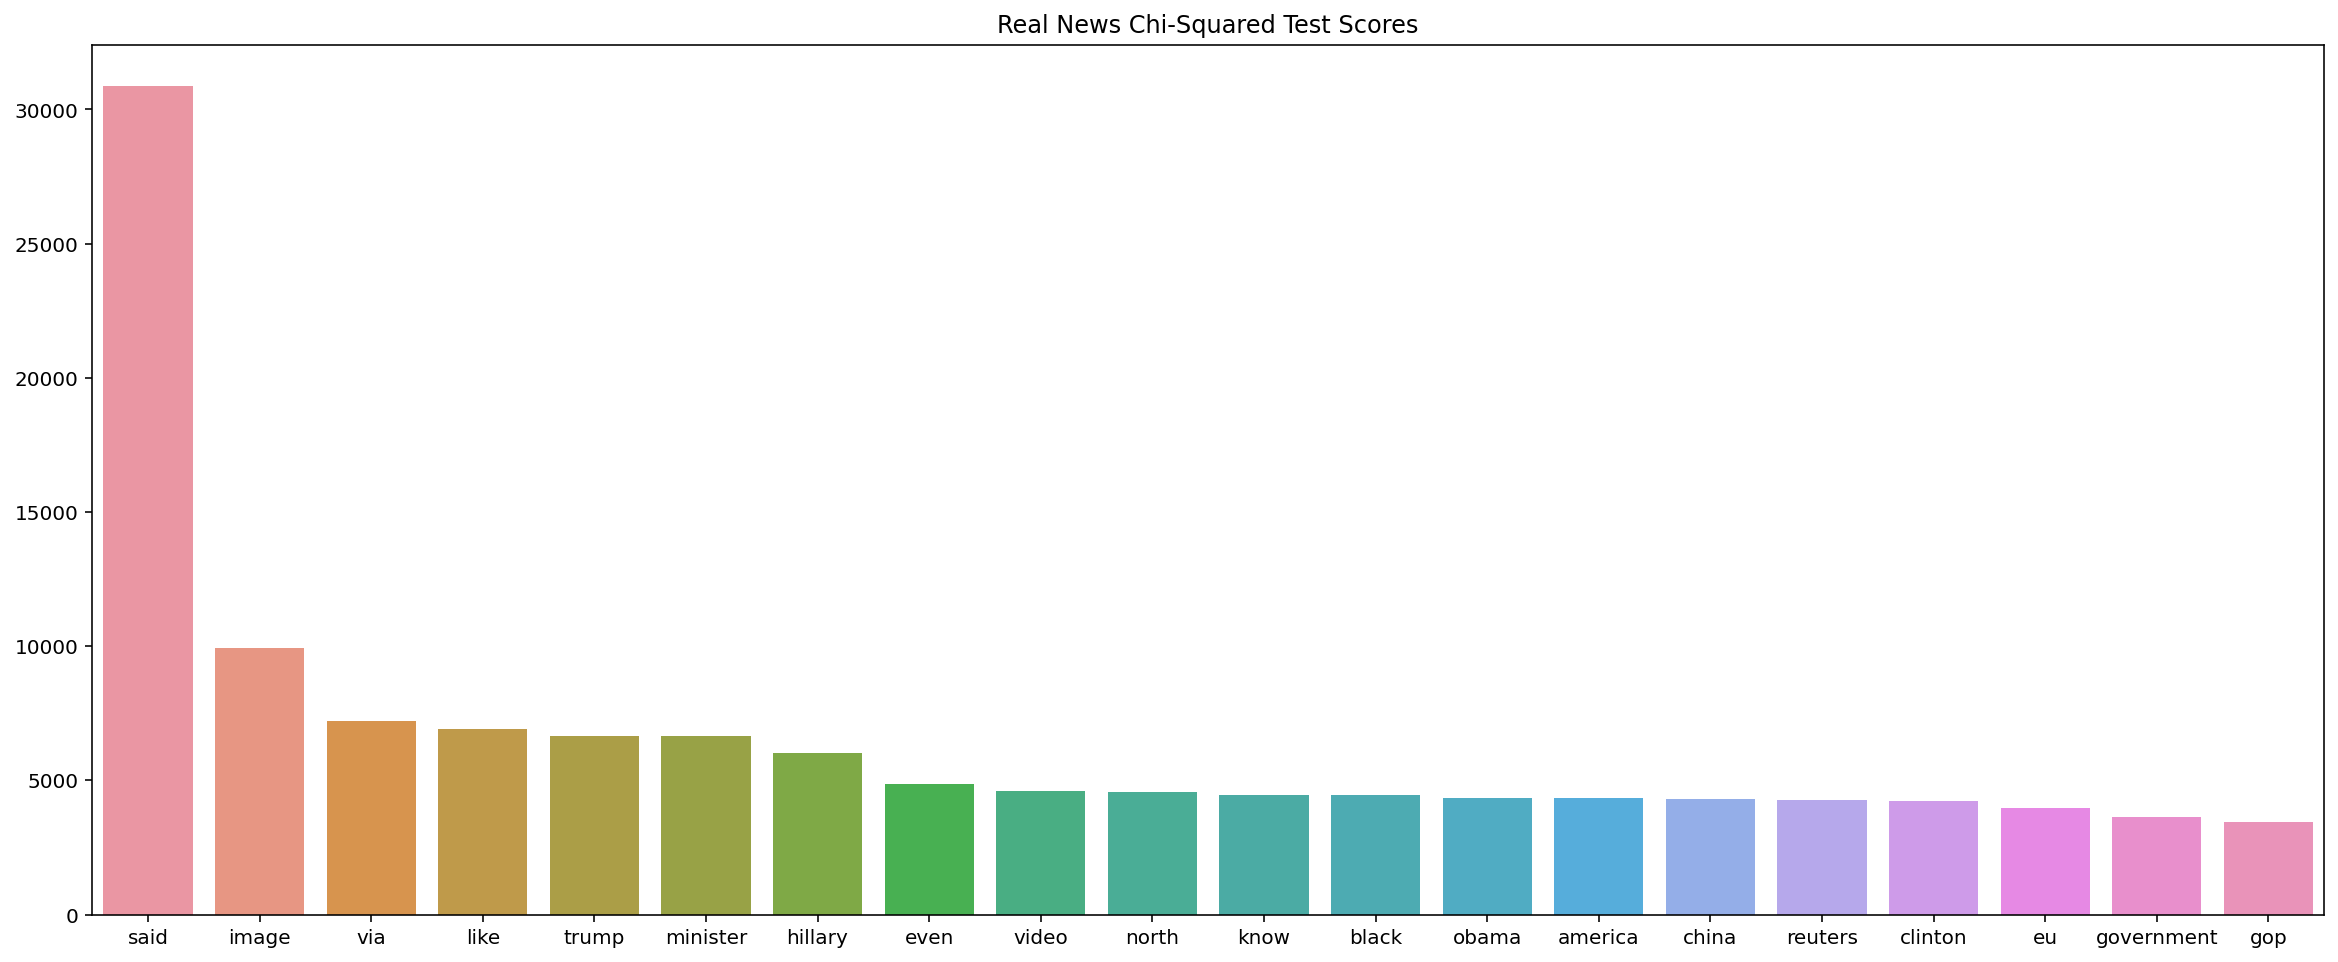

In [192]:
plt.figure(figsize = (20,8)) 
sns.barplot(x=list(sorted_chi2_scores.keys())[:20], y=list(sorted_chi2_scores.values())[:20])
plt.title("Real News Chi-Squared Test Scores")
plt.show()

> Clearly, we can see that words like `said`, `black`, `obama`, `clinton` are words with high prominenece. But we should also look into topic modelling to understand the presence of these words in news. 

#### Topic Modelling 

In [193]:
def topics(model, feature_names, no_top_words):
    _dict = {}
    for topic_idx, topic in enumerate(model.components_):
        _dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return _dict

In [194]:
lda = LatentDirichletAllocation(random_state=42).fit(_vec)
topic_all = topics(lda, vectorizer.get_feature_names(), 15)

In [195]:
vectorizer_fake = CountVectorizer()
vectorizer_true = CountVectorizer()

_fake_df = vectorizer_fake.fit_transform(news_df[news_df.target == "fake"].lemmatize_data)
_real_df = vectorizer_true.fit_transform(news_df[news_df.target == "real"].lemmatize_data)

lda_fake = LatentDirichletAllocation(random_state=42, n_components=5).fit(_fake_df)
lda_real = LatentDirichletAllocation(random_state=42, n_components=5).fit(_real_df)

topic_real = topics(lda_real, vectorizer_true.get_feature_names(), 15)
topic_fake = topics(lda_fake, vectorizer_fake.get_feature_names(), 15)

In [196]:
def plot_clouds(_dict, title):
    for topic, words in zip(list(_dict.keys())[:4], list(_dict.values())[:4]):
        cloud = " ".join(words)
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white',  
                        min_font_size = 10).generate(cloud) 
        plt.figure(figsize = (4, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title(title + ' Topics '+ str(topic+1))
        plt.show() 

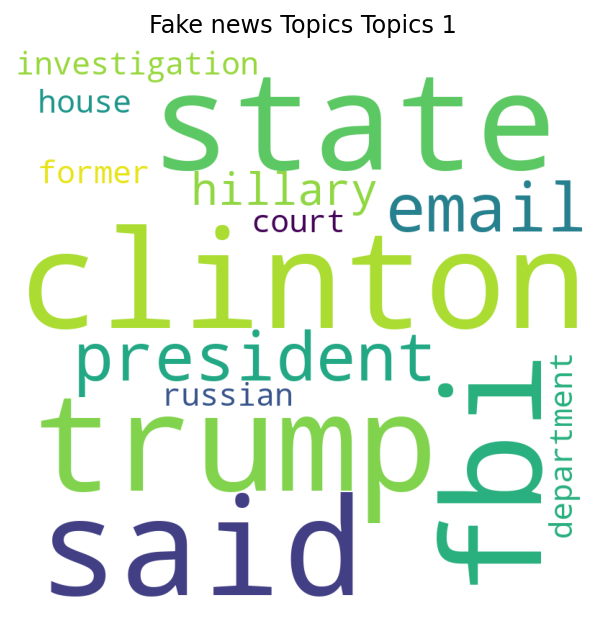

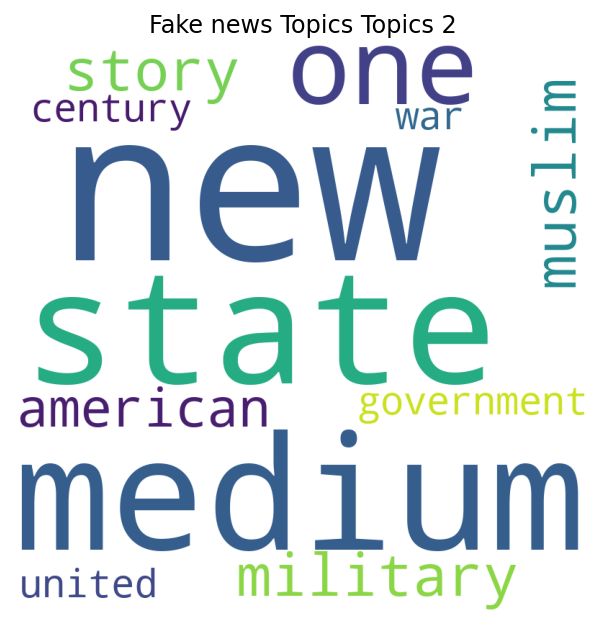

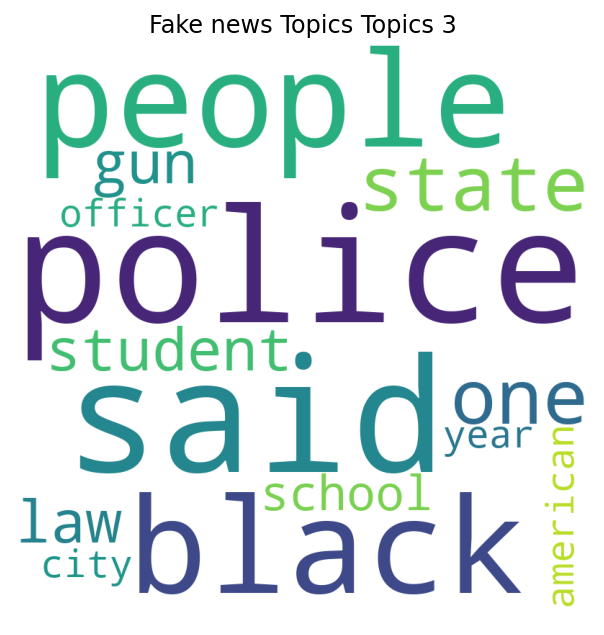

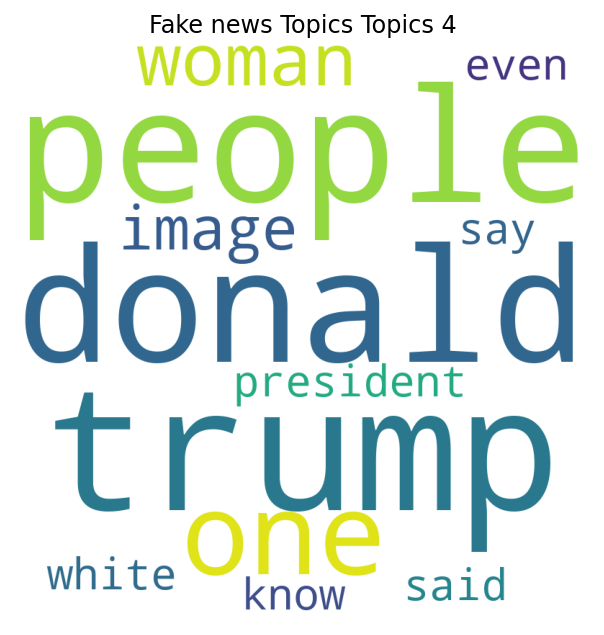

In [197]:
plot_clouds(topic_fake, 'Fake news Topics')

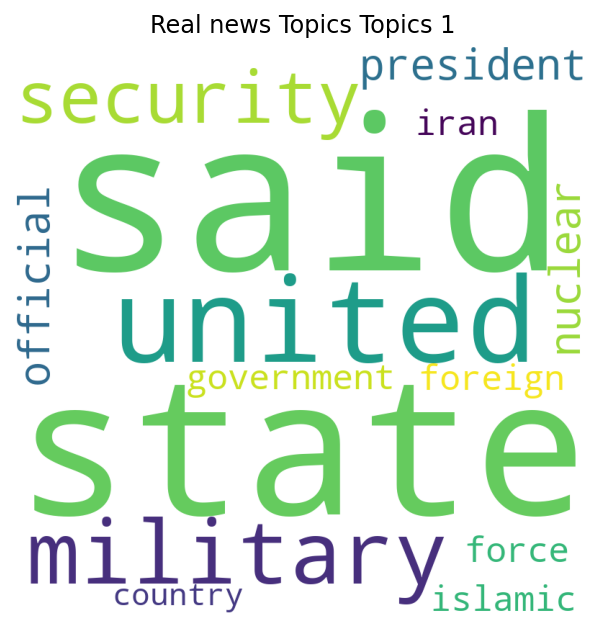

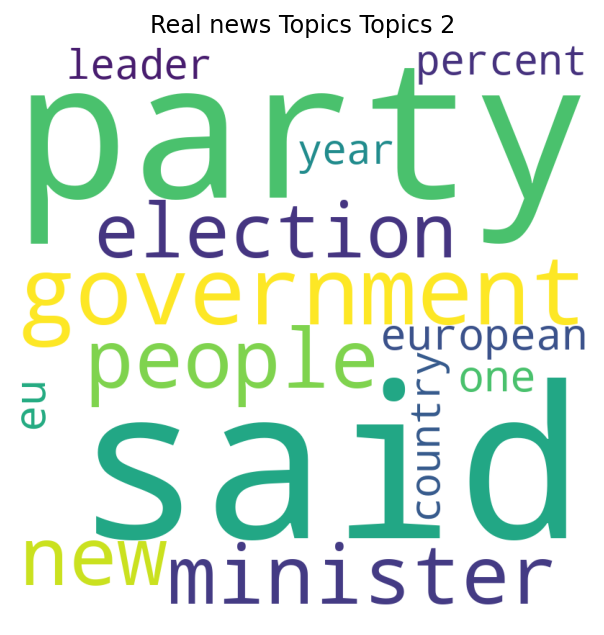

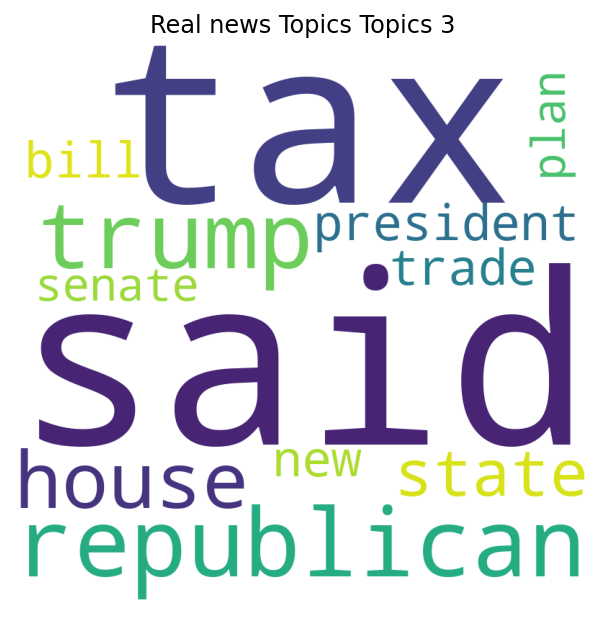

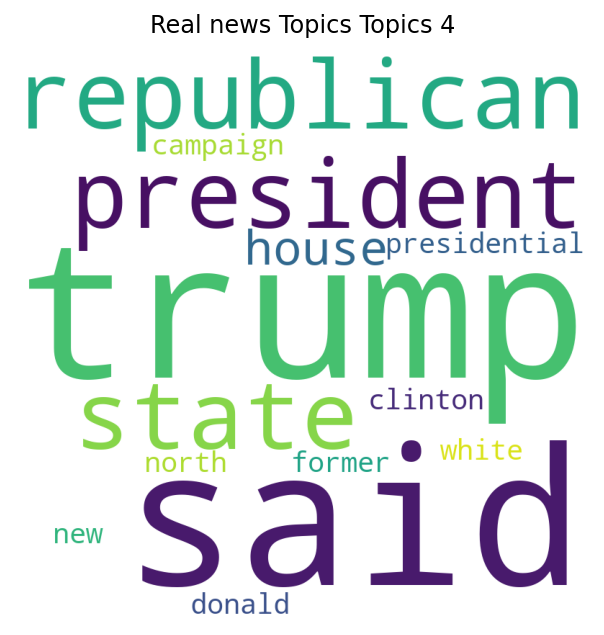

In [198]:
plot_clouds(topic_real, 'Real news Topics')

> Looking at the topics we observe that the words with large prominence are present in the topics as well.

Now, let's look at n-grams to check what 

In [199]:
def generateNgramsText(text, n):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [200]:
def generateTopNgrams(corpus, column_name, n, top_n):
    all_n_grams = []
    for text in corpus[column_name]:
        all_n_grams.extend(generateNgramsText(text, n))
        
    sort_orders = sorted(OrderedDict(Counter(all_n_grams)).items(), key=lambda x: x[1], reverse=True)
    result_dict = {item[0]: item[1] for item in sort_orders[: top_n]}
    return result_dict

##### Fake News n-gram Analysis

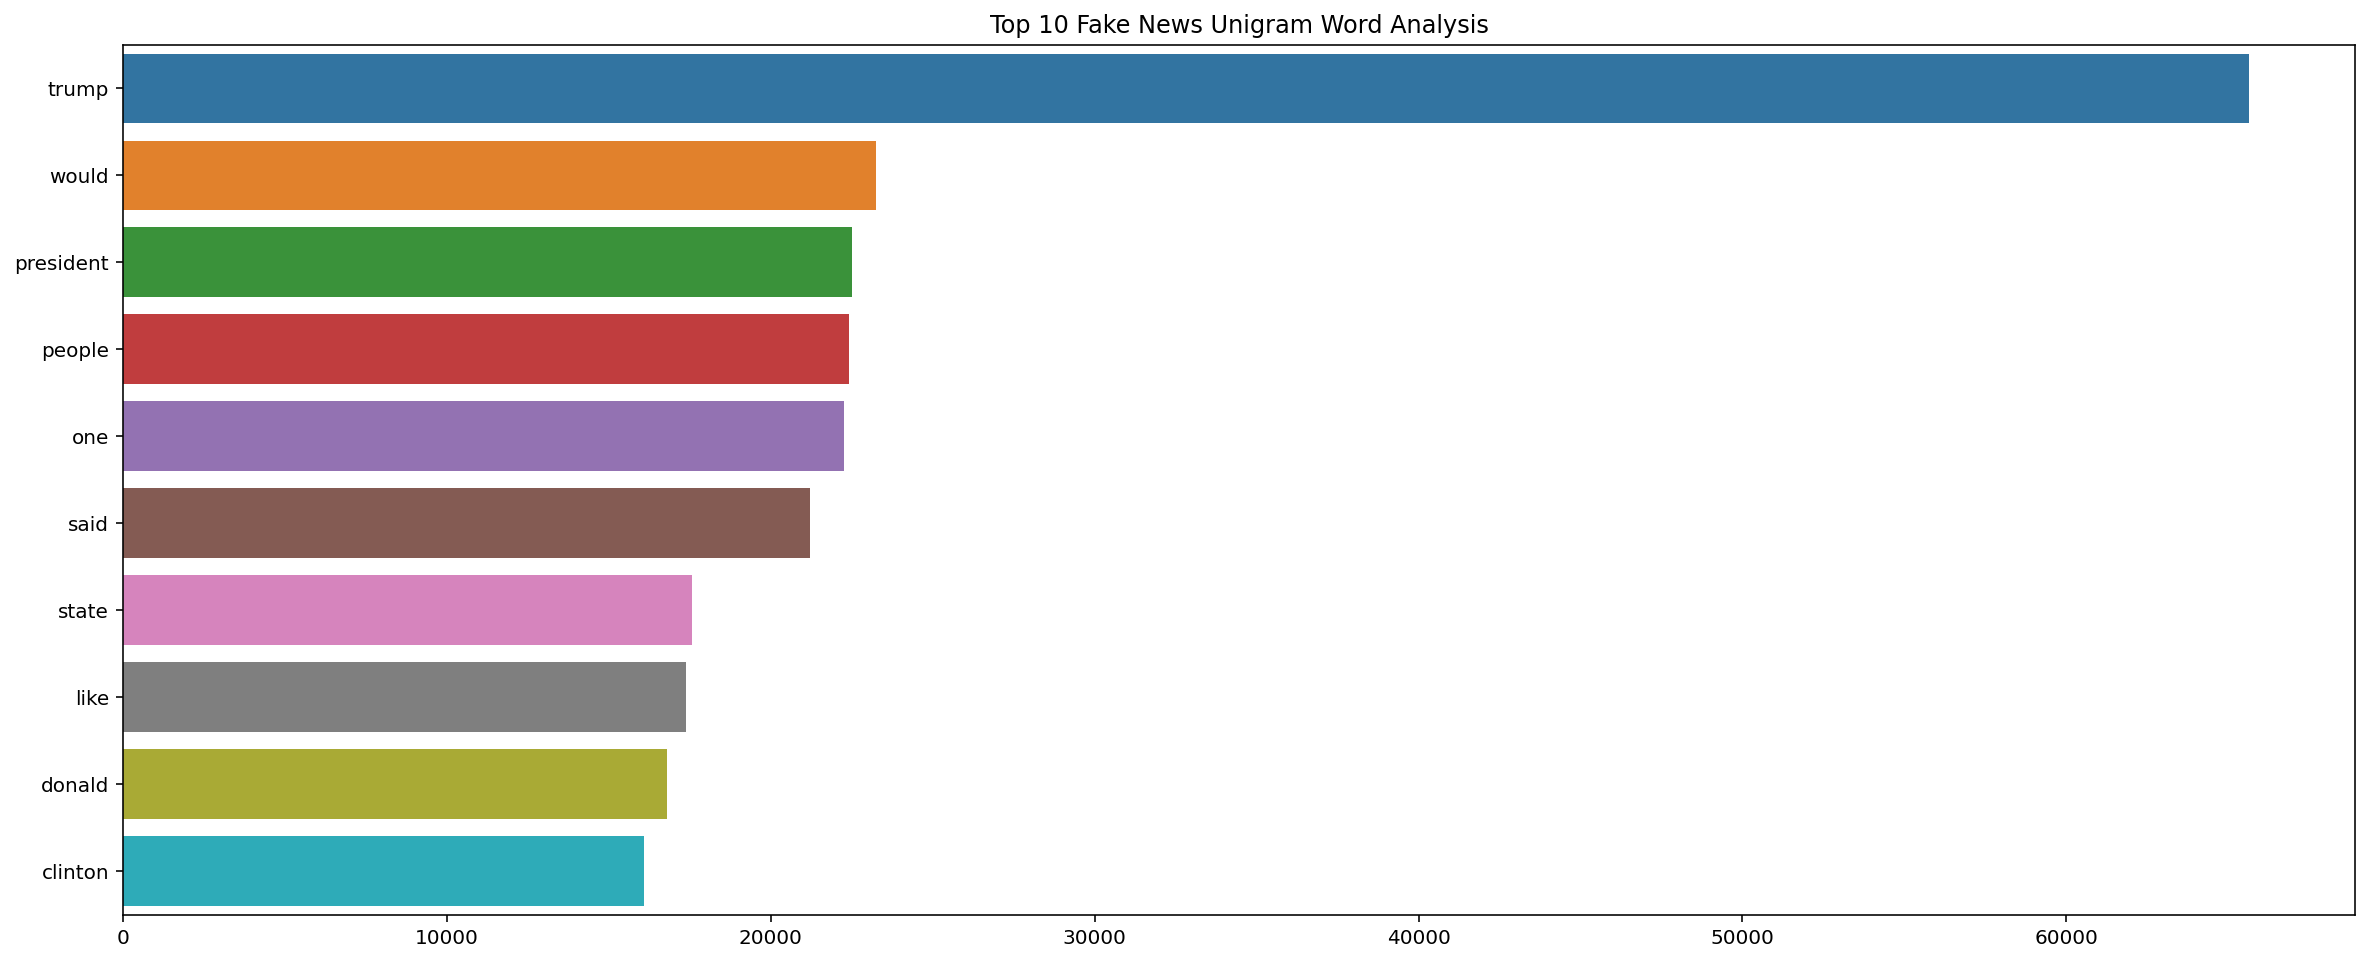

In [201]:
top_10_unigram = generateTopNgrams(news_df[news_df.target == "fake"], "lemmatize_data", 1, 10)

plt.figure(figsize = (20,8)) 
sns.barplot(x= list(top_10_unigram.values()), y=list(top_10_unigram.keys()))
plt.title("Top 10 Fake News Unigram Word Analysis")
plt.show()

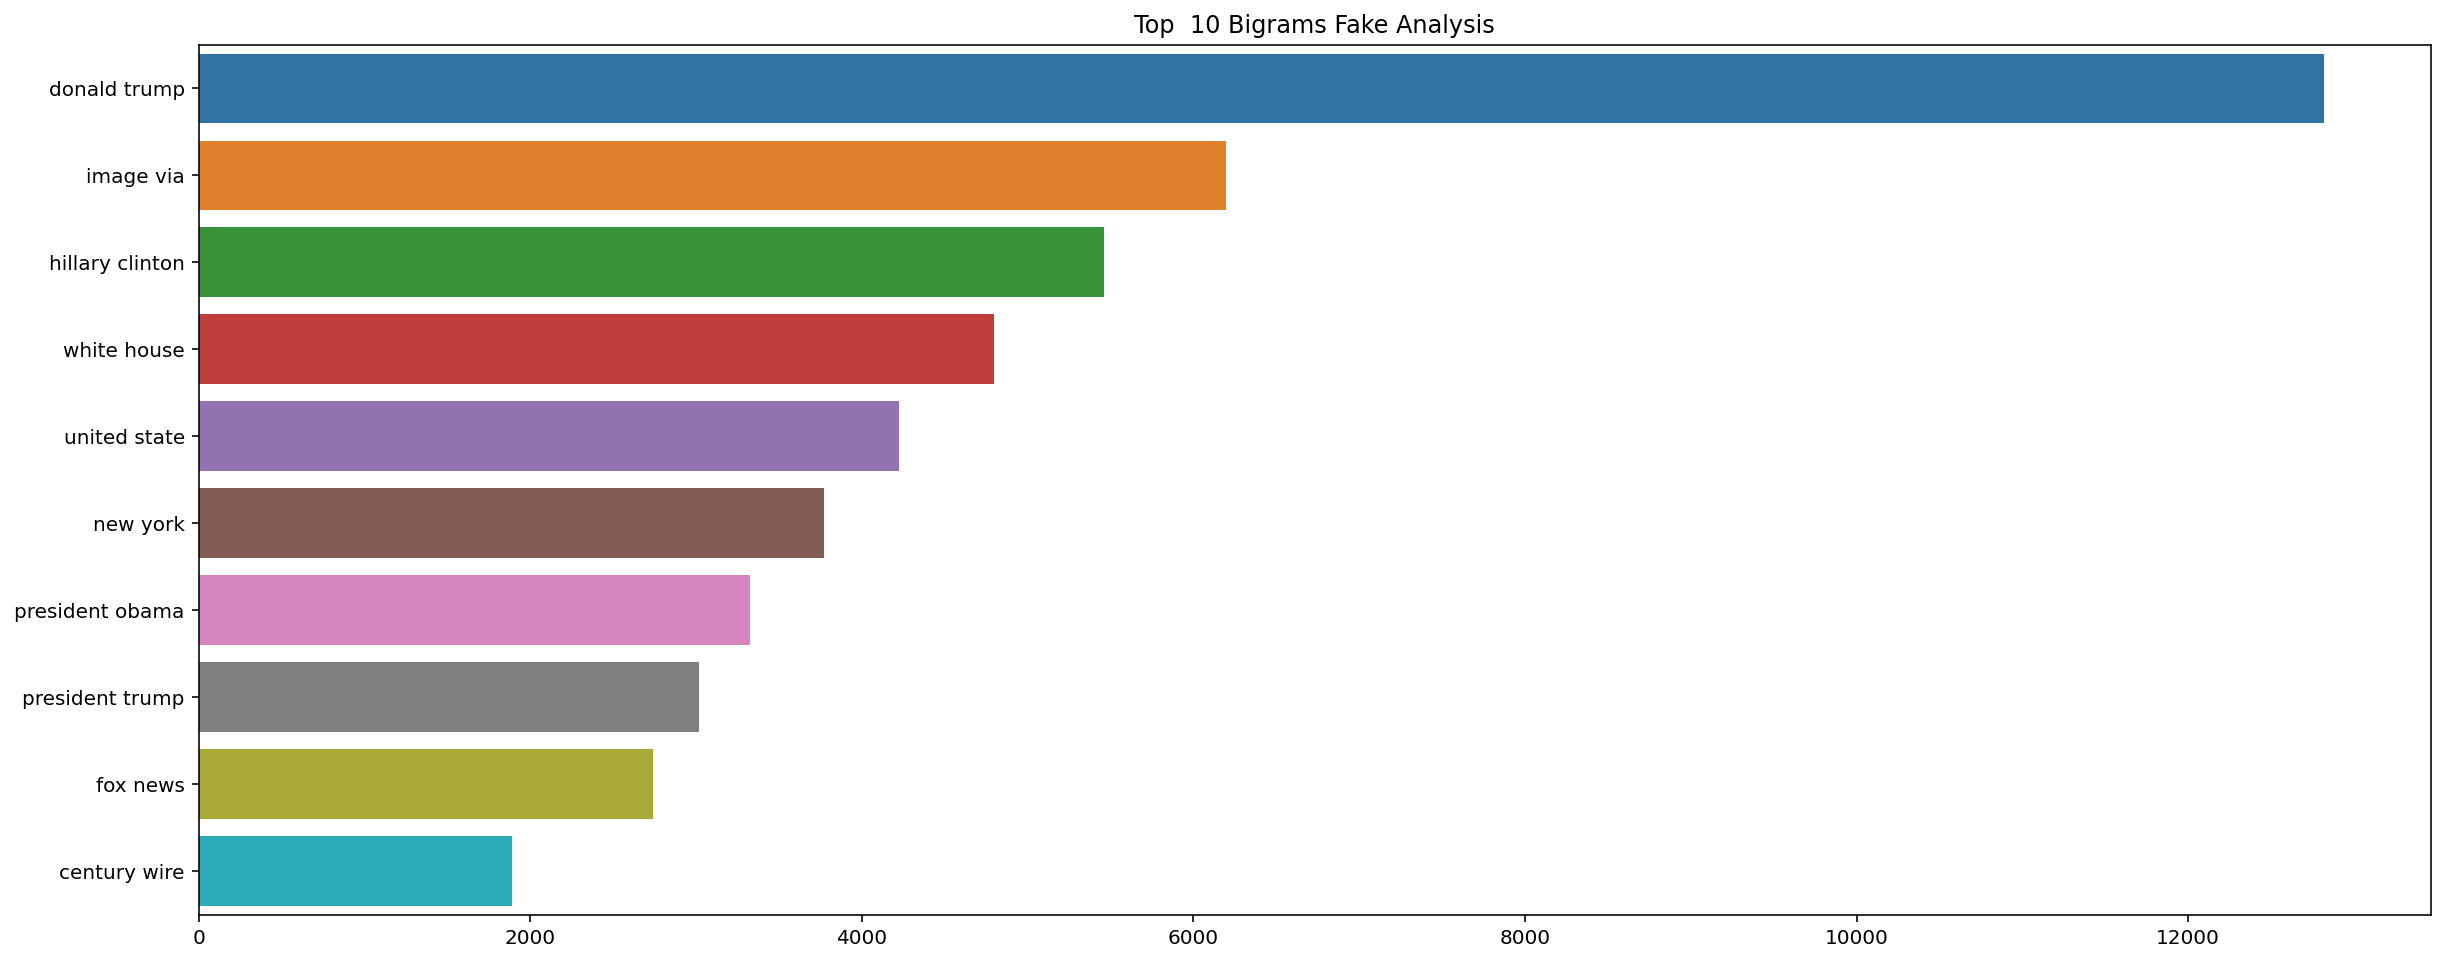

In [202]:
top_10_bigrams = generateTopNgrams(news_df[news_df.target == "fake"], "lemmatize_data", 2, 10)

plt.figure(figsize = (20,8)) 
sns.barplot(x=list(top_10_bigrams.values()), y= list(top_10_bigrams.keys()))
plt.title("Top  10 Bigrams Fake Analysis")
plt.show()

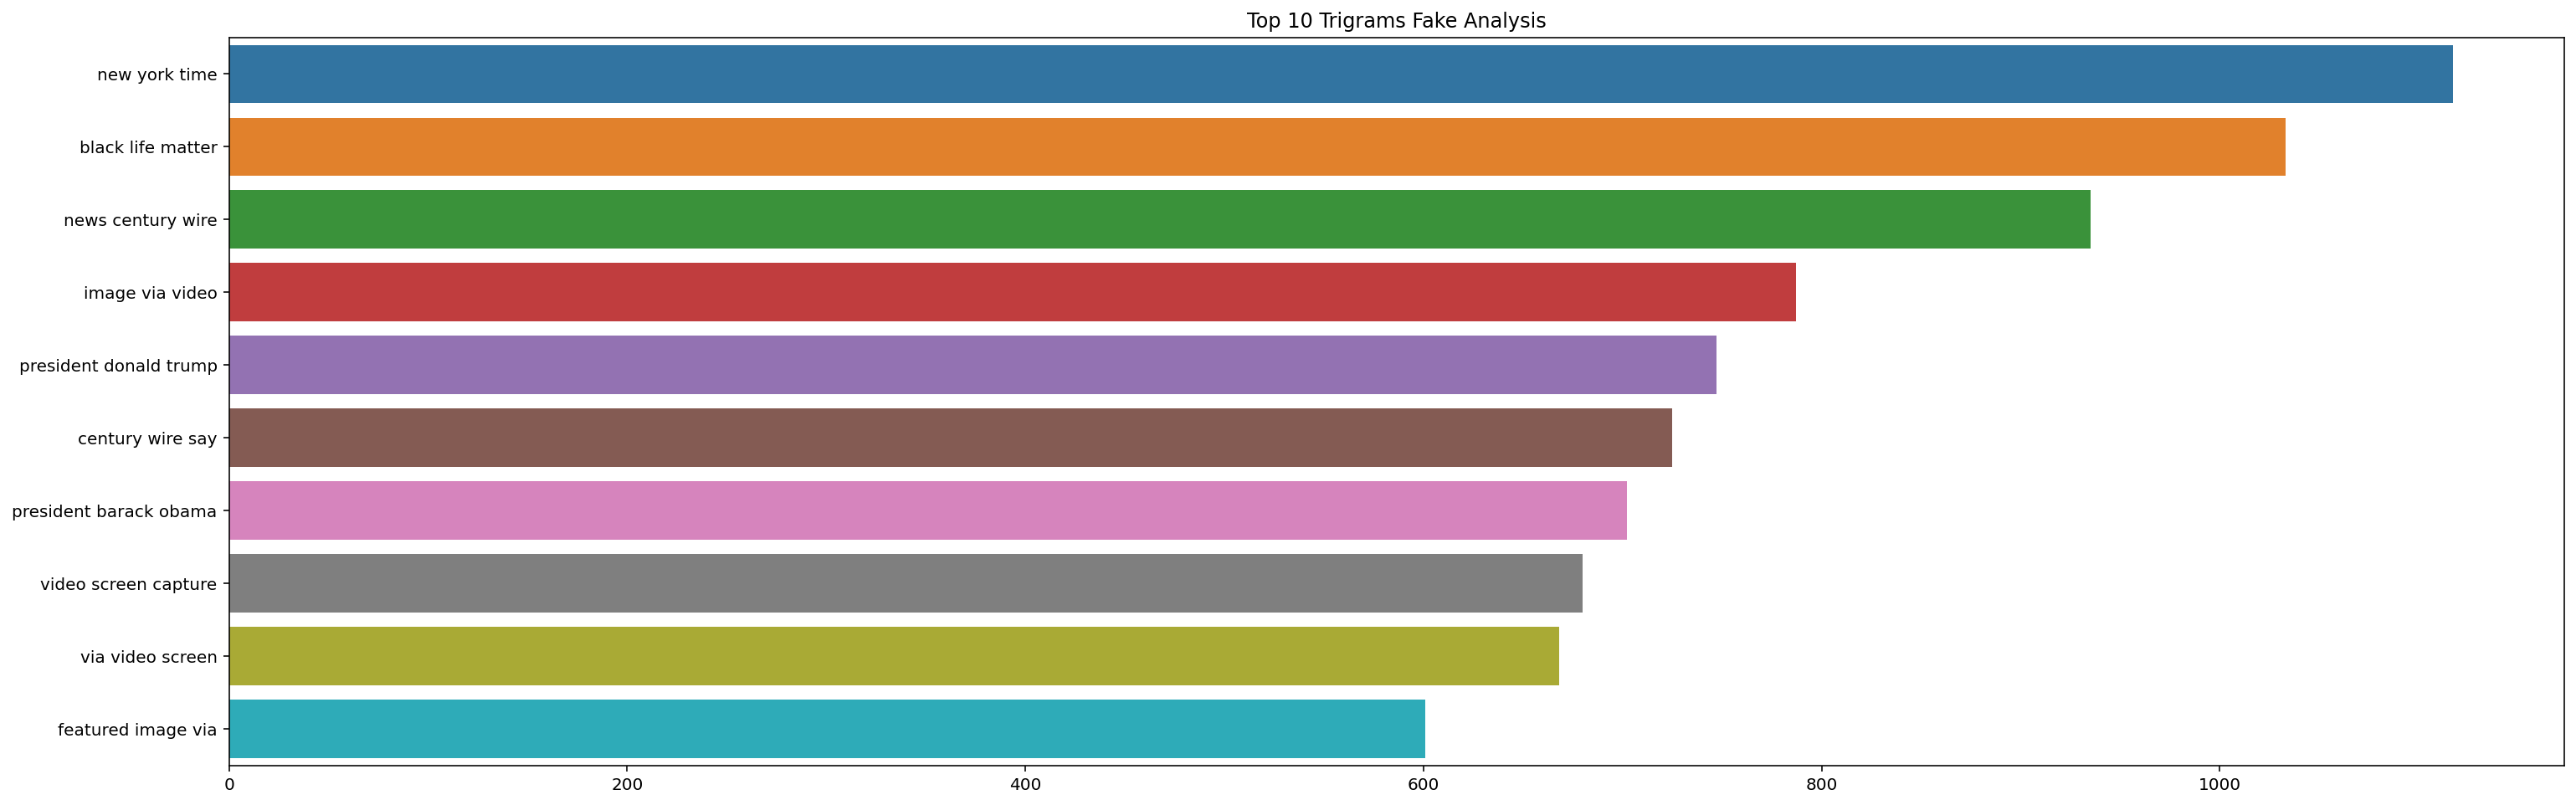

In [203]:
top_10_trigrams = generateTopNgrams(news_df[news_df.target == "fake"], "lemmatize_data", 3, 10)

plt.figure(figsize = (25,8)) 
sns.barplot(x=list(top_10_trigrams.values()), y=list(top_10_trigrams.keys()))
plt.title("Top 10 Trigrams Fake Analysis")
plt.show()

##### Real News n-gram Analysis

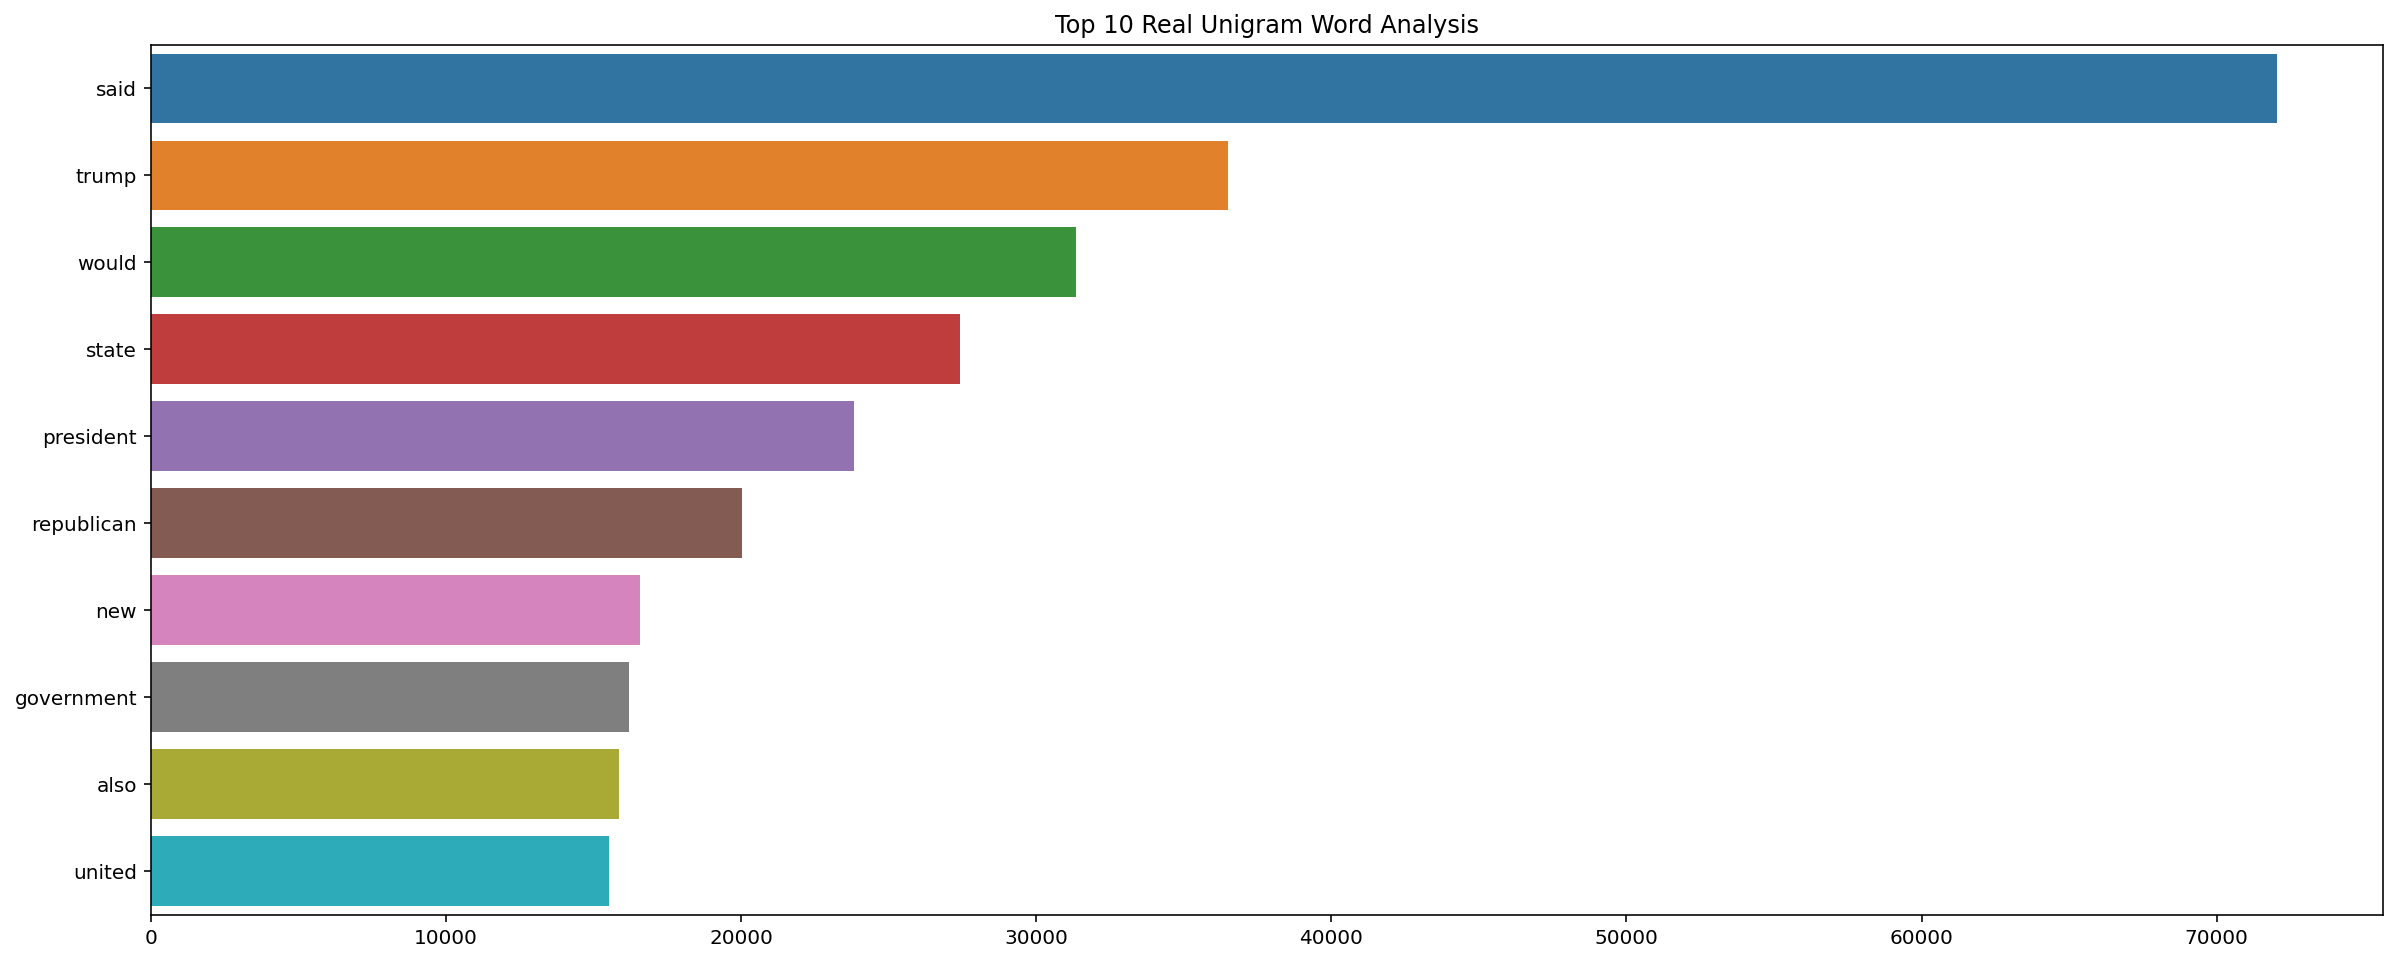

In [204]:
top_10_unigram = generateTopNgrams(news_df[news_df.target == "real"], "lemmatize_data", 1, 10)

plt.figure(figsize = (20,8)) 
sns.barplot(x= list(top_10_unigram.values()), y=list(top_10_unigram.keys()))
plt.title("Top 10 Real Unigram Word Analysis")
plt.show()

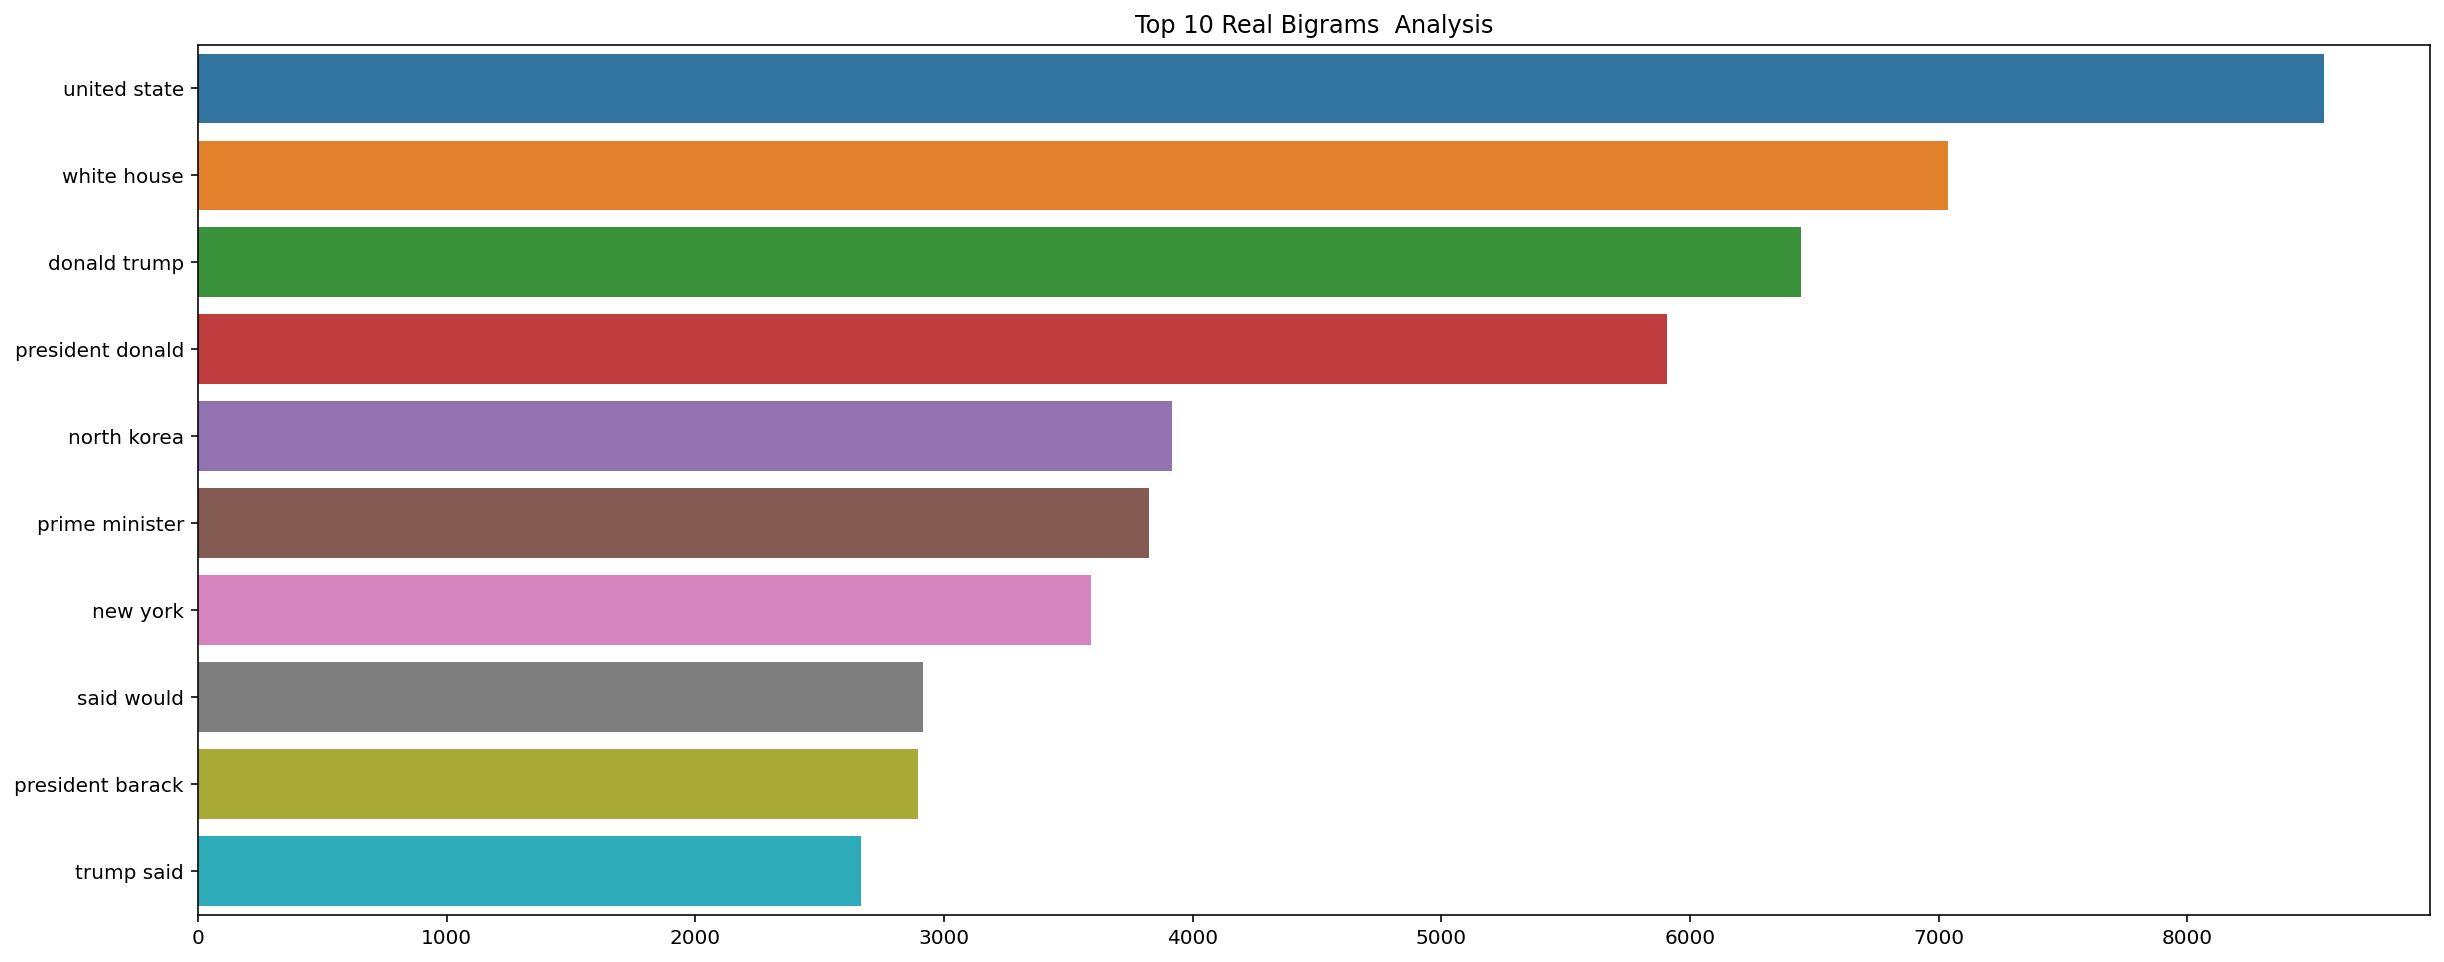

In [205]:
top_10_bigrams = generateTopNgrams(news_df[news_df.target == "real"], "lemmatize_data", 2, 10)

plt.figure(figsize = (20,8)) 
sns.barplot(x=list(top_10_bigrams.values()), y= list(top_10_bigrams.keys()))
plt.title("Top 10 Real Bigrams  Analysis")
plt.show()

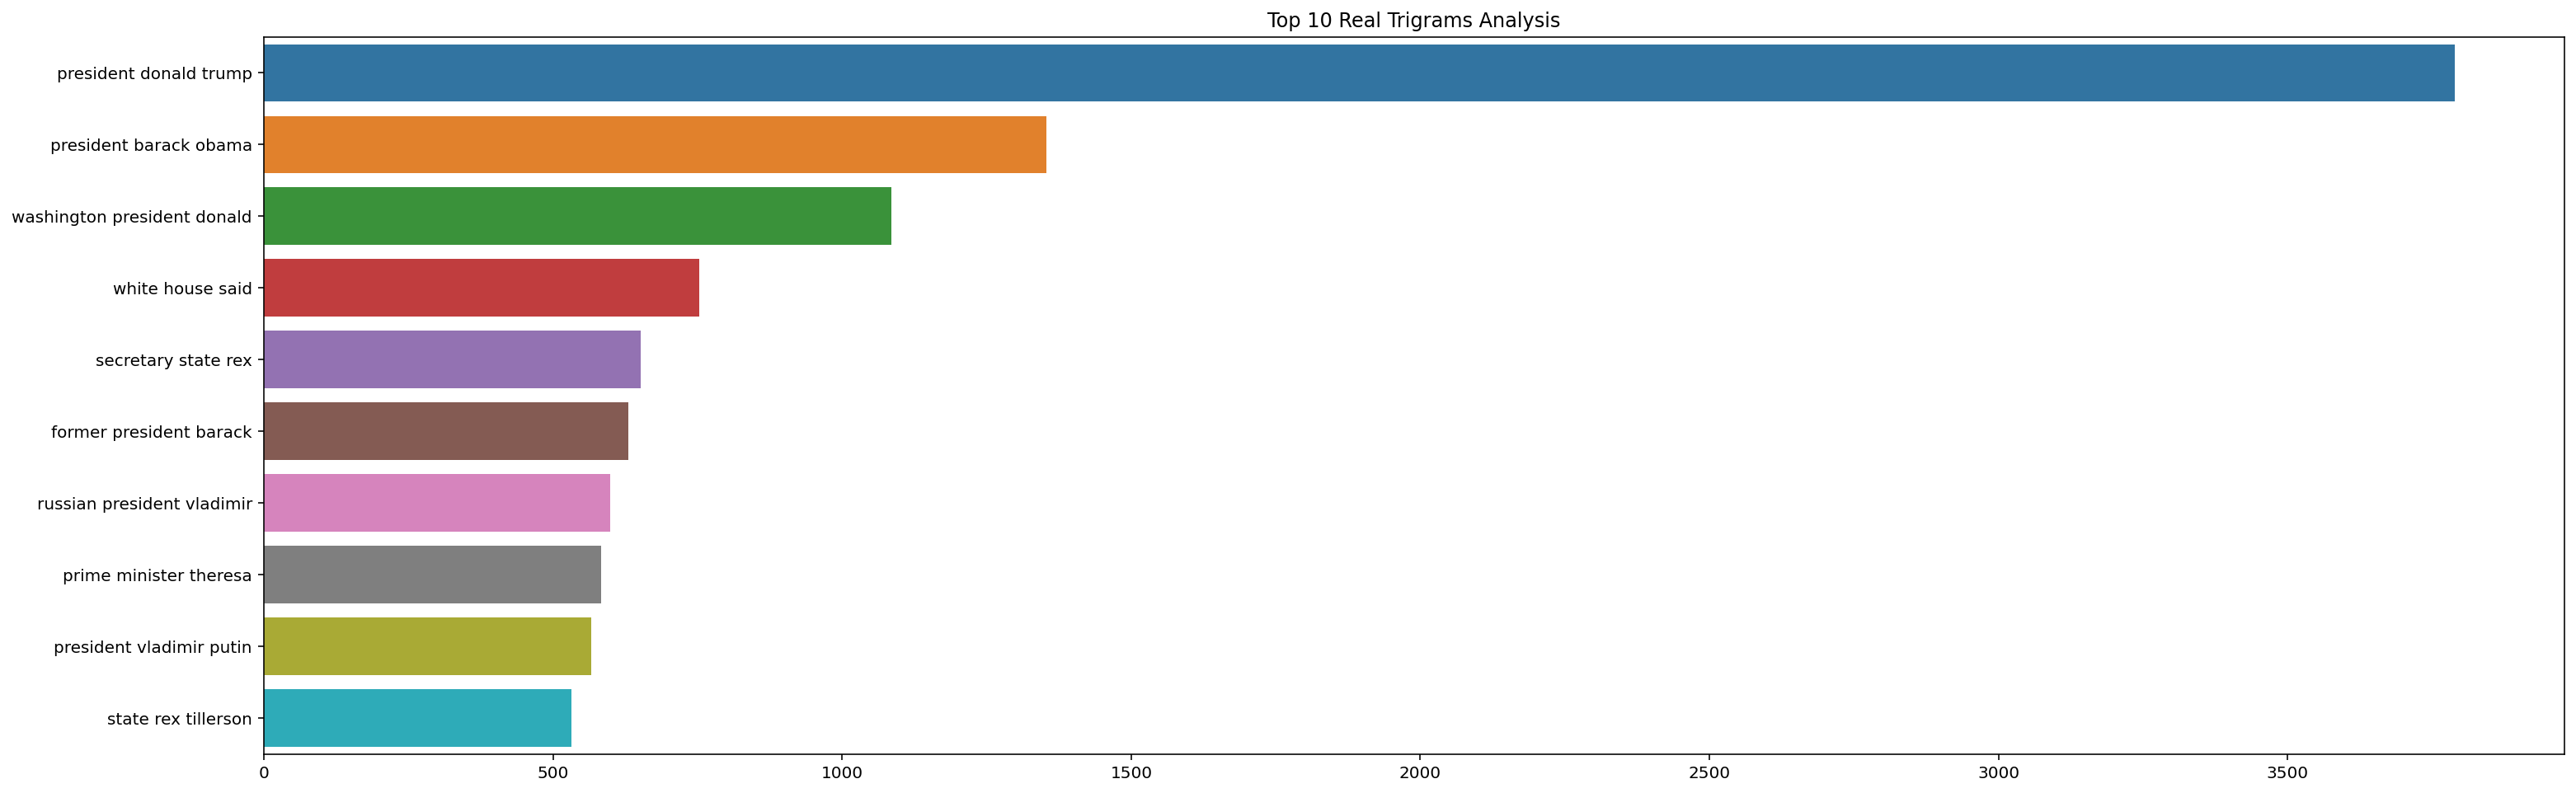

In [206]:
top_10_trigrams = generateTopNgrams(news_df[news_df.target == "real"], "lemmatize_data", 3, 10)
plt.figure(figsize = (25,8)) 
sns.barplot(x=list(top_10_trigrams.values()), y=list(top_10_trigrams.keys()))
plt.title("Top 10 Real Trigrams Analysis")
plt.show()

> Analyzing the n-grams for fake and real news apparently the both the set of news have same kind of n-grams. 

_____
____

> **Conclusion of data analysis:** Before we start feature engineering and model building, we need to keep in my mind results of our data analysis. We observed that real and fake news have a lot of common keywords. N-gram analysis shows us that most common n-grams are also quite similar. After doing chi-squared analysis, we found most prominent words are common among both kind of news. This is a clear indication that our dataset might be biased. The sources of datasets are distinct but still the datasets have lots of commonalities. Let's first see how the most basic models in the field of machine learning works on our dataset, then we can move on to more complicated models to achieve better accuracy.

## Feature Engineering 

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

In [208]:
X = news_df.lemmatize_data
y = news_df.target_category

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.2, random_state=7)

In [210]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

____

## Model Building

For the first algorithm let's use one of the classification algorithms from passive-aggressive algorithms. You can find description on link: https://scikit-learn.org/stable/modules/linear_model.html#passive-aggressive  

#### Passive Agressive Algorithm

In [211]:
def passiveAggressive(X_train, y_train):
    pac = PassiveAggressiveClassifier(max_iter=50)
    pac.fit(tfidf_train,y_train)
    return pac

In [212]:
pac = passiveAggressive(X_train, y_train)

_____

#### Logistic Regression Algorithm

Let's build logisitic regression and also check how many K-best features can we use to build a reasonable accuracy model.

In [213]:
def selectKLogisticRegression(X, y):
    tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
    X_tfidf = tfidf_vectorizer.fit_transform(X)

    accuracy_scores_k = {}
    
    for i in range(1, 11):
        select_percent_features = X_tfidf.shape[1] * 0.1 * i
        sel_chi2 = SelectKBest(chi2, k=int(select_percent_features))

        X_chi2 = sel_chi2.fit_transform(X_tfidf, y)

        X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, 
                                                    test_size=0.2, random_state=7)

        clf = LogisticRegression()
        model = clf.fit(X_train, y_train)
        predict = model.predict(X_test)
        score = accuracy_score(y_test, predict)
        accuracy_scores_k[str(i)] = score
        
    return accuracy_scores_k

____

#### Deep Learning Model

Let's build a deep learning model to check if we can achieve higher accuracy. We will use GloVec (Global Vectors) embedding to represent data features for the model. We will use GloVec representation build by Stanford for our model.<br>
I found this link to be helpful in learning and implementing GloVec representation: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

We will load GloVec vectors into a dictionary. 

In [214]:
embeddings_index = {}
with open("../input/gloveicg/Glove/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_index[word] = vector
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


We will use only 5000 features and the max length of our feature will be 300. These are hyperparameters which needs to be adjusted in real world training and deployment of model. These hyperparameters can be handled using something like grid search. 

In [215]:
max_features = 1000
max_length = 300

Tokenize the training set.

In [216]:
t = Tokenizer(num_words=max_features)
t.fit_on_texts(X_train)

We will encode the training dataset and use padding (because our news text might be of varying length) for the sequences.

In [217]:
vocab_size = len(t.word_index) + 1
train_encoded_docs = t.texts_to_sequences(X_train)
train_padded_docs = pad_sequences(train_encoded_docs, maxlen=max_length, padding='post')

In [231]:
test_encoded_docs = t.texts_to_sequences(X_test)
test_padded_docs = pad_sequences(test_encoded_docs, maxlen=max_length, padding='post')

In [219]:
vocab_size

69593

We will create a word-embedding matrix for the words which we see in our training data. We will use the tokenizer which we ran on our training data to locate the word and give it weight using the pre-defined GloVec embedding which we loaded. 

In [221]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

We will create our embedding layer which we have created using the weights from GloVec word embedding. Since we do not want to change the weights while training our model, we set trainable to False. 

In [222]:
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)

Create and Train Model

In [225]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

In [226]:
model = Sequential()
model.add(e)
model.add(LSTM(units=128 , return_sequences = True, recurrent_dropout = 0.2 , dropout = 0.2))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          20877900  
_________________________________________________________________
lstm_6 (LSTM)                (None, 300, 128)          219648    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 21,149,069
Trainable params: 271,169
Non-trainable params: 20,877,900
_________________________________________________________________


We can use different types of algorithms to handle learning rate. 

In [ ]:
"""def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

callback_list = [LearningRateScheduler(step_decay)]"""

In [227]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)
callback_list = [learning_rate_reduction]

Training Deep Learning Model

In [229]:
history = model.fit(train_padded_docs, y_train, batch_size = 256, validation_split=0.25, 
                    epochs = 10, callbacks=callback_list, shuffle=True)


Epoch 1/10
104/104 [==============================] - 243s 2s/step - loss: 0.6057 - accuracy: 0.6504 - val_loss: 0.6932 - val_accuracy: 0.5140
Epoch 2/10
104/104 [==============================] - 240s 2s/step - loss: 0.6923 - accuracy: 0.5219 - val_loss: 0.6884 - val_accuracy: 0.5690
Epoch 3/10
104/104 [==============================] - 240s 2s/step - loss: 0.6391 - accuracy: 0.5971 - val_loss: 0.2519 - val_accuracy: 0.9110
Epoch 4/10
104/104 [==============================] - 240s 2s/step - loss: 0.1900 - accuracy: 0.9351 - val_loss: 0.1261 - val_accuracy: 0.9554
Epoch 5/10
104/104 [==============================] - 243s 2s/step - loss: 0.1263 - accuracy: 0.9569 - val_loss: 0.1212 - val_accuracy: 0.9586
Epoch 6/10
104/104 [==============================] - 246s 2s/step - loss: 0.1002 - accuracy: 0.9663 - val_loss: 0.0846 - val_accuracy: 0.9709
Epoch 7/10
104/104 [==============================] - 246s 2s/step - loss: 0.0958 - accuracy: 0.9685 - val_loss: 0.0957 - val_accuracy: 0.9709

____
____

## Model Evaluation

Let's check accuracy of passive aggressive classification algorithm... 

In [ ]:
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

> This is a really good accuracy. But we need to check what is causing such high accuracy.   

____

In [ ]:
k_scores = selectKLogisticRegression(X, y)
plt.figure(figsize = (25,10)) 
sns.lineplot(x=list(k_scores.keys()), y=list(k_scores.values()))
plt.show()

> Even with 10% features we are able to achieve good accuracy. Let's check if we can use even less number of features and predict with similarly level of accuracy. 

In [ ]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(X)
sel_chi2 = SelectKBest(chi2, k=500)
X_chi2 = sel_chi2.fit_transform(X_tfidf, y)

X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, 
                                            test_size=0.2, random_state=7)

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
predict = model.predict(X_test)
score = accuracy_score(y_test, predict)

In [ ]:
score

In [ ]:
confusion_matrix(y_test,predict)

In [ ]:
print("We can predict with accuracy %s using only %s features. We are using only %s percent of features. "
      %(score*100, max_features, round(max_features/(len(real_corpus) + len(fake_corpus))*100, 4)))

> By only using only 500 words we can achieve a really high accuracy. This shows that our dataset have high inherent bias. 

____

#### Evaluate deep learning model

In [233]:
model.evaluate(test_padded_docs, y_test)

277/277 [==============================] - 44s 158ms/step - loss: 0.0710 - accuracy: 0.9780


[0.0710366815328598, 0.9780368804931641]

> We have got a really good accuracy using deep learning model. 

____
____

## Conclusion

* One of the things to note is that building a fake news classifier in real world is not as easy as it is while working on a cleaned Kaggle Dataset.
* While working on the dataset we found that the dataset had bias in terms of words that appear in both real and fake news. 
* Although, we have achoeved a really high accuracy, we still need to observe the model accuracy in real world to find whether our model generalizes well or not. 
* There are a lot of hyperparameters which we need to adjust while putting a model in prodcution. We can use existing functions like GridSearch or we can build our own functions.
* Working on a dataset on Kaggle does not give you the clear picture of how the dataset was collected. This is something very important before we start using the data in a professional setting.

*If you have any feedback, contact me on my linkedin profile.*

____
____